# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques.


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model.
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [ ]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),

        nn.Linear(32, 10)
    )

    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [ ]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
# Compute the mean and standard deviation for each channel
images = torch.stack([img for img, _ in train_dataset]) # (N x C x W x H)
mean = torch.mean(images, (0, 2, 3))
std = torch.std(images, (0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [ ]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std), # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

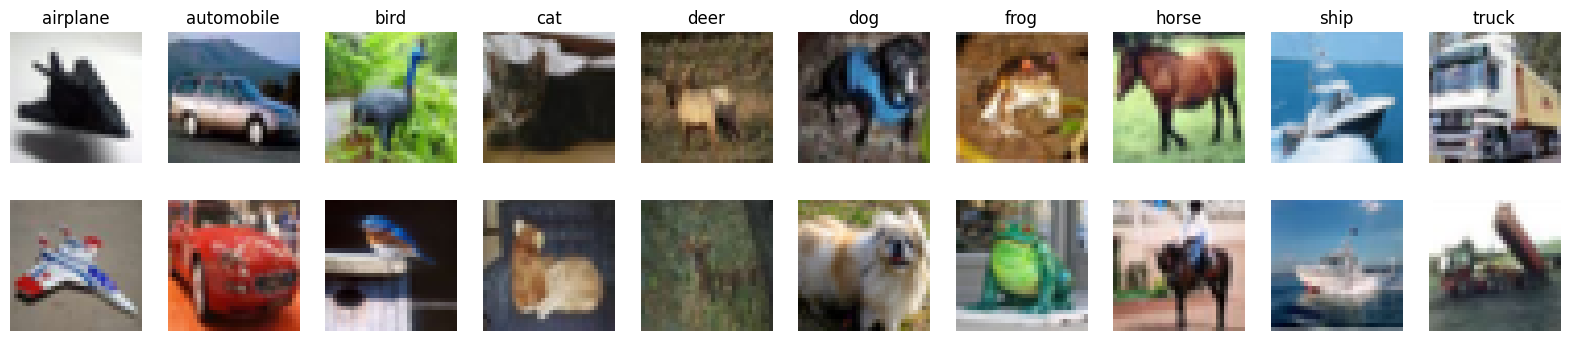

In [ ]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

### 1.4: Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth'))
model.to(device);

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


In [ ]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Best validation loss: 0.8255


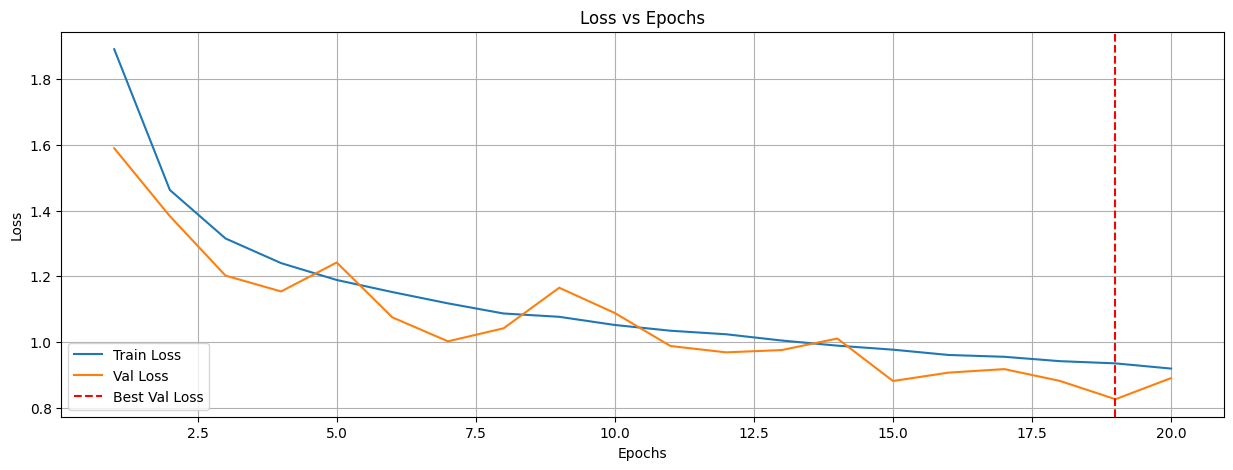

In [ ]:
# Plot the losses after training
# epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A: From the plot we can see that the model do not converge very well, and the validation accuracy is a little bit noisy. As a first naive strategy, one could try to train for longer (say 40 epochs), but the results do not improve so much, as we can see in the following plots:

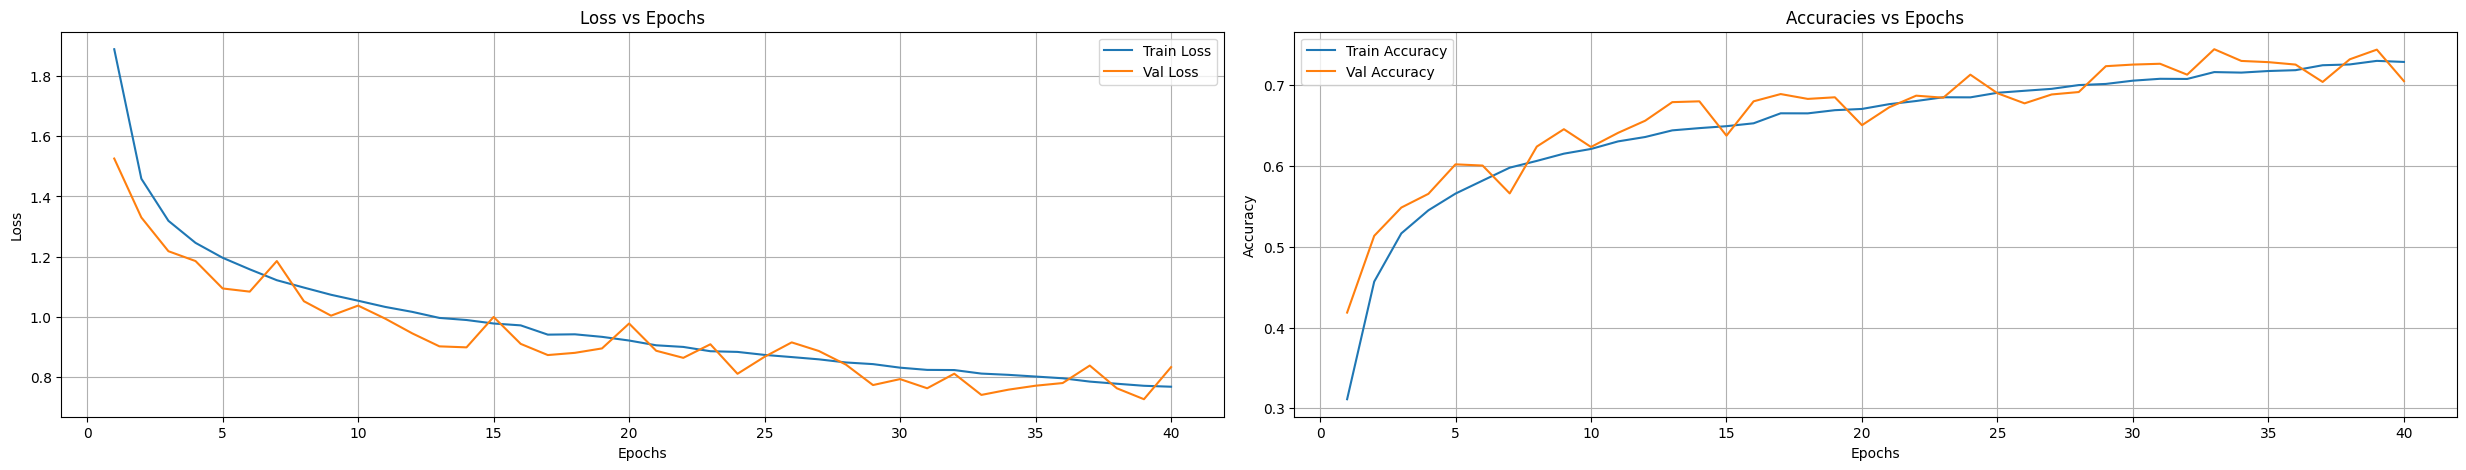

Similar results are obtained with smaller learning rate of 1E-4 (and obviously a longer training of 40 epochs, because of smaller update steps for each iteration), proving a smaller learning rate can help stabilize training, as it can be seen from the following plots:

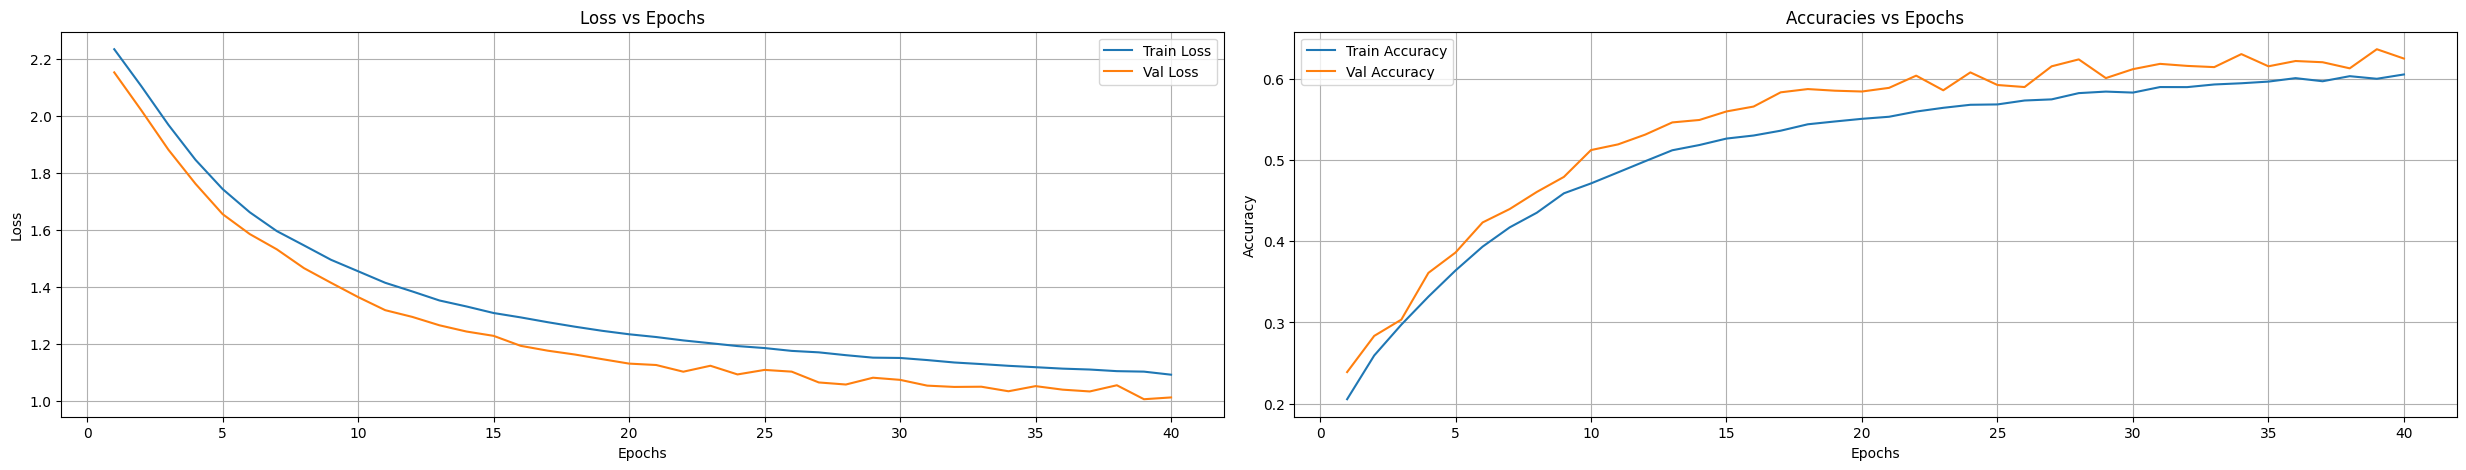

However, looking at the batch size, we can see how it is a pretty large number. Even if large batches better approximate the gradients, with a too high batch size we are doing less updates in an epoch, and so the model requires much more epochs to converge. With a smaller batch size (equal 16), with the drawback of a little bit longer training, we obtain in 20 epochs much better results, as it is shown in the following plots:

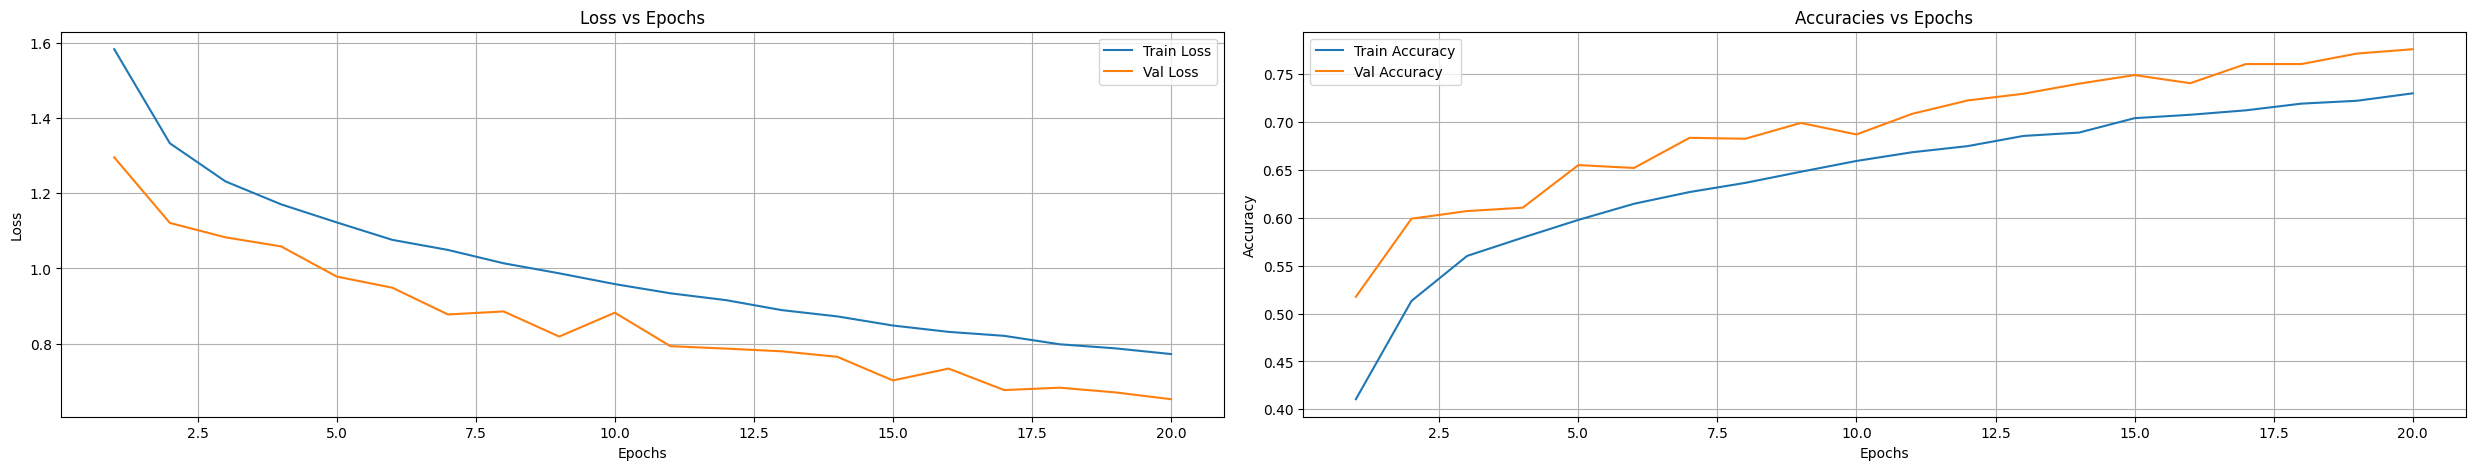

As a final proof, we trained the model for 60 epochs and a batch size of 32, achieving very good performances as it is shown here:

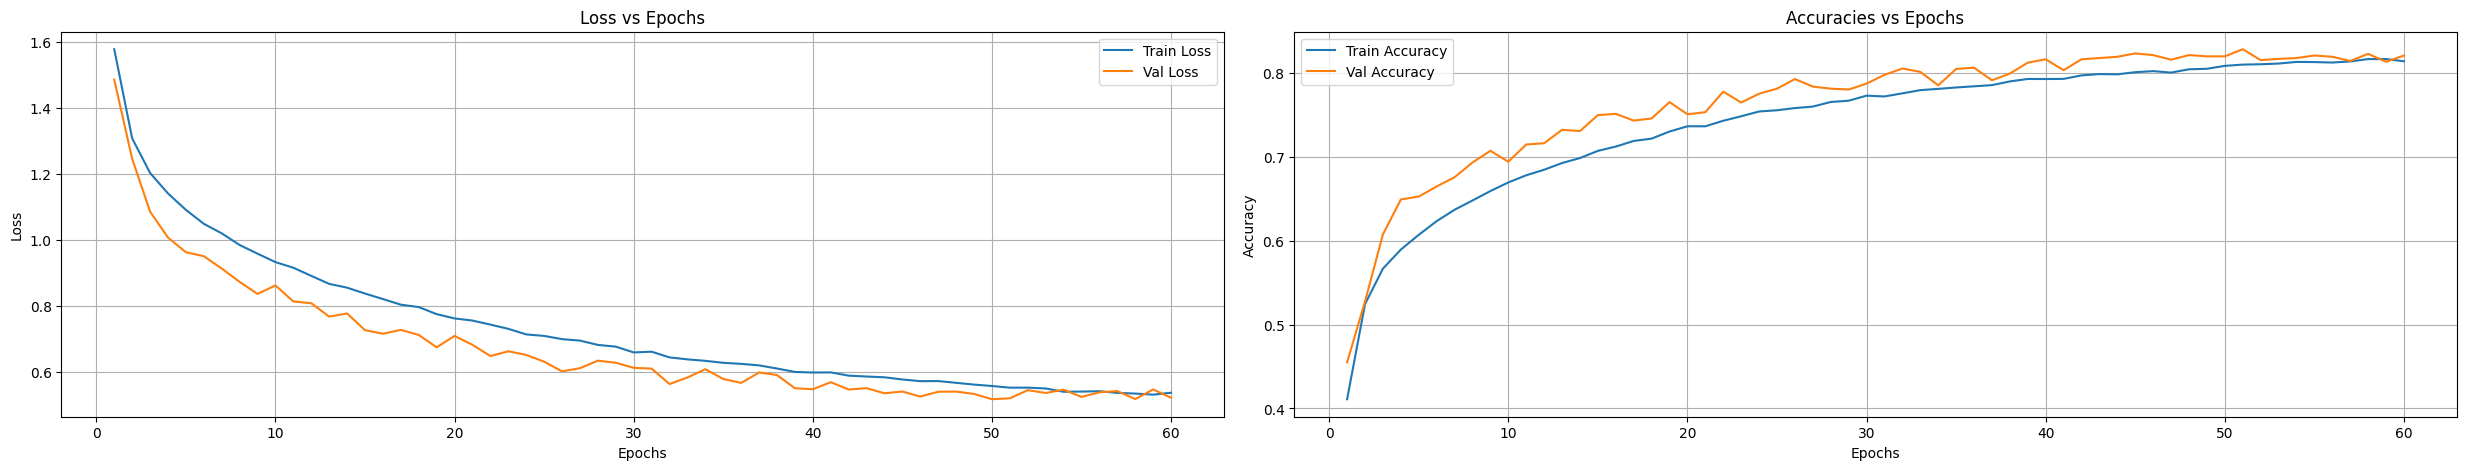

Even bettering the performances of best_model.pth weights:

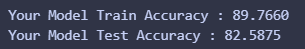

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [ ]:
# accuracy
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [ ]:
# your model
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth'))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 72.1220
Your Model Test Accuracy : 70.3500


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [ ]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario,
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned.

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data.
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [ ]:
#train
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(train_dataset)):
    if train_dataset[i][1] != 0: keep.append(i)
    else: forget.append(i)

retain_dataset = torch.utils.data.Subset(train_dataset, keep)
forget_dataset = torch.utils.data.Subset(train_dataset, forget)
retain_loader = DataLoader(retain_dataset, batch_size = batch_size)
forget_loader = DataLoader(forget_dataset, batch_size = batch_size)

In [ ]:
#validation
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(val_dataset)):
    if val_dataset[i][1] != 0: keep.append(i)
    else: forget.append(i)

retain_dataset_val = torch.utils.data.Subset(val_dataset, keep)
forget_dataset_val = torch.utils.data.Subset(val_dataset, forget)
retain_loader_val = DataLoader(retain_dataset_val, batch_size = batch_size)
forget_loader_val = DataLoader(forget_dataset_val, batch_size = batch_size)

In [ ]:
#test
'''
Add your code below
'''
keep,forget = [],[]
for i in range(len(test_dataset)):
    if test_dataset[i][1] != 0: keep.append(i)
    else: forget.append(i)

retain_dataset_test = torch.utils.data.Subset(test_dataset, keep)
forget_dataset_test = torch.utils.data.Subset(test_dataset, forget)
retain_loader_test = DataLoader(retain_dataset_test, batch_size = batch_size)
forget_loader_test = DataLoader(forget_dataset_test, batch_size = batch_size)

### 2.2: Training Loop

In [ ]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")


    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [ ]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, retain_loader_val, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch [1/10]: 100%|██████████| 88/88 [00:20<00:00,  4.26it/s, loss=0.485]


Epoch [1/10], Average Loss: 0.5279
Validation Loss: 0.5176


Epoch [2/10]: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s, loss=0.473]


Epoch [2/10], Average Loss: 0.5026
Validation Loss: 0.5059


Epoch [3/10]: 100%|██████████| 88/88 [00:14<00:00,  5.97it/s, loss=0.48] 


Epoch [3/10], Average Loss: 0.4980
Validation Loss: 0.5104


Epoch [4/10]: 100%|██████████| 88/88 [00:14<00:00,  6.23it/s, loss=0.471]


Epoch [4/10], Average Loss: 0.4962
Validation Loss: 0.4990


Epoch [5/10]: 100%|██████████| 88/88 [00:14<00:00,  5.97it/s, loss=0.461]


Epoch [5/10], Average Loss: 0.4929
Validation Loss: 0.5053


Epoch [6/10]: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s, loss=0.472]


Epoch [6/10], Average Loss: 0.4913
Validation Loss: 0.5055


Epoch [7/10]: 100%|██████████| 88/88 [00:15<00:00,  5.76it/s, loss=0.439]


Epoch [7/10], Average Loss: 0.4888
Validation Loss: 0.5015


Epoch [8/10]: 100%|██████████| 88/88 [00:14<00:00,  6.01it/s, loss=0.452]


Epoch [8/10], Average Loss: 0.4882
Validation Loss: 0.5002


Epoch [9/10]: 100%|██████████| 88/88 [00:14<00:00,  6.17it/s, loss=0.425]


Epoch [9/10], Average Loss: 0.4859
Validation Loss: 0.4993


Epoch [10/10]: 100%|██████████| 88/88 [00:14<00:00,  6.21it/s, loss=0.435]


Epoch [10/10], Average Loss: 0.4819
Validation Loss: 0.4949


**Below there is the evaluation of your unlearned by fine-tuning model**

In [ ]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")

print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

Retain set Accuracy: 88.8822
Forget set Accuracy: 30.2400
Test set Accuracy: 77.3375
Test set Retain Accuracy: 83.2778
Test set Forget Accuracy: 23.8750


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: The idea of unlearning, by fine tuning, is based on the model training on the data minus the class (or classes) that must be unlearned. Intuitively, by training on the remaining classes the gradients, with an appropriate learning rate, would point towards a location of the loss function where the associated weights would be less specialized for the class that wants to be unlearned.

Regarding the values of forget and retain sets during training, it has been observed that the fine-tuned model performed slightly better than the original one on retain training set.
Moreover the test accuracy on the original set slightly decreased with respect to the original model by $\sim$ 3%, which is an acceptable tradeoff for the desired result and combined with the accuracy obtained on retain test set and forget test set it also shows how the model is effectively unlearning the target class. In fact, the model perform very poorly on the forget test set, while obtaining good performances on the retain test set. It is also worth noting that both retain and forget obtained a worse accuracy than the training respective sets, which is a typical tendency, because the model has not seen any of the sample in the test set.

To better visualize and understand the unlearning task, we did a plot of the error rates, in which it became very clear that the 0-th label was being unlearned. (Please note that the plots have different scales on the y axis)

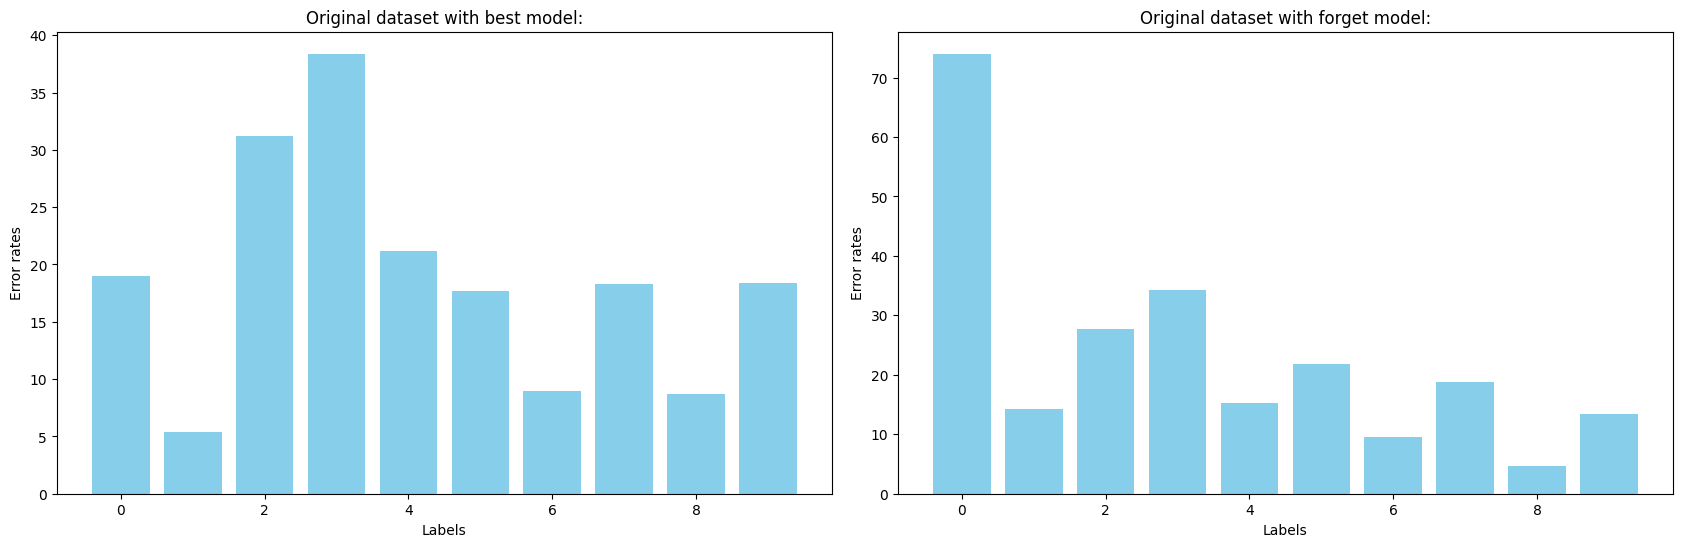

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [ ]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [ ]:
# **IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**
'''
Add your code below
'''

losses = []
losses_val = []

for epoch in range(num_epochs):
    epoch_loss = 0
    gold_model.train()
    for inputs, labels in tqdm(retain_loader, total=len(retain_loader), leave=True):

        inputs = inputs.to(device)
        labels = labels.to(device)

        pred = gold_model(inputs)
        loss = criterion(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(retain_loader)
    losses.append(avg_loss)

    scheduler.step(avg_loss)
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    loss_val = 0
    gold_model.eval()
    with torch.no_grad():
        for inputs, labels in retain_loader_val:
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = gold_model(inputs)
            loss = criterion(pred, labels)
            loss_val += loss.item()

        avg_val_loss = loss_val / len(retain_loader_val)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        if epoch == 0:
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")


100%|██████████| 88/88 [00:15<00:00,  5.86it/s]


Epoch [1/20], Average Loss: 2.2302
Validation Loss: 2.1501


100%|██████████| 88/88 [00:15<00:00,  5.73it/s]


Epoch [2/20], Average Loss: 2.0959
Validation Loss: 2.0118


100%|██████████| 88/88 [00:16<00:00,  5.42it/s]


Epoch [3/20], Average Loss: 1.9572
Validation Loss: 1.8610


100%|██████████| 88/88 [00:17<00:00,  5.03it/s]


Epoch [4/20], Average Loss: 1.8250
Validation Loss: 1.7347


100%|██████████| 88/88 [00:15<00:00,  5.67it/s]


Epoch [5/20], Average Loss: 1.7108
Validation Loss: 1.6317


100%|██████████| 88/88 [00:14<00:00,  5.94it/s]


Epoch [6/20], Average Loss: 1.6205
Validation Loss: 1.5504


100%|██████████| 88/88 [00:15<00:00,  5.54it/s]


Epoch [7/20], Average Loss: 1.5446
Validation Loss: 1.4902


100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


Epoch [8/20], Average Loss: 1.4837
Validation Loss: 1.4297


100%|██████████| 88/88 [00:16<00:00,  5.49it/s]


Epoch [9/20], Average Loss: 1.4313
Validation Loss: 1.3817


100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


Epoch [10/20], Average Loss: 1.3872
Validation Loss: 1.3487


100%|██████████| 88/88 [00:17<00:00,  5.12it/s]


Epoch [11/20], Average Loss: 1.3500
Validation Loss: 1.3006


100%|██████████| 88/88 [00:17<00:00,  5.18it/s]


Epoch [12/20], Average Loss: 1.3142
Validation Loss: 1.2776


100%|██████████| 88/88 [00:14<00:00,  5.94it/s]


Epoch [13/20], Average Loss: 1.2859
Validation Loss: 1.2335


100%|██████████| 88/88 [00:14<00:00,  6.01it/s]


Epoch [14/20], Average Loss: 1.2606
Validation Loss: 1.2330


100%|██████████| 88/88 [00:14<00:00,  5.98it/s]


Epoch [15/20], Average Loss: 1.2423
Validation Loss: 1.2083


100%|██████████| 88/88 [00:15<00:00,  5.71it/s]


Epoch [16/20], Average Loss: 1.2188
Validation Loss: 1.1849


100%|██████████| 88/88 [00:14<00:00,  5.95it/s]


Epoch [17/20], Average Loss: 1.2075
Validation Loss: 1.1552


100%|██████████| 88/88 [00:14<00:00,  6.02it/s]


Epoch [18/20], Average Loss: 1.1899
Validation Loss: 1.1636


100%|██████████| 88/88 [00:14<00:00,  6.02it/s]


Epoch [19/20], Average Loss: 1.1763
Validation Loss: 1.1581


100%|██████████| 88/88 [00:14<00:00,  5.96it/s]


Epoch [20/20], Average Loss: 1.1618
Validation Loss: 1.1521


Best validation loss: 1.1521


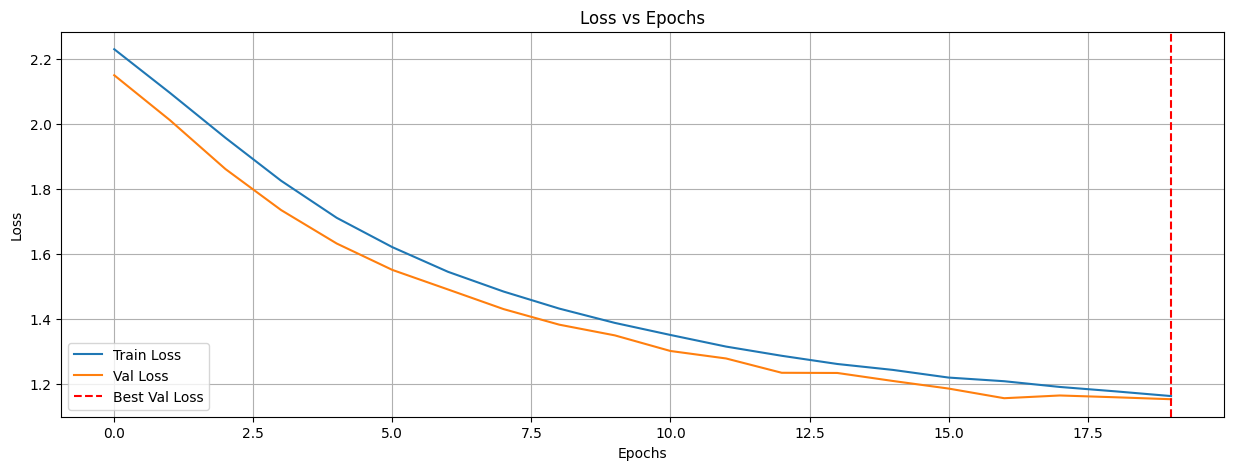

In [ ]:
#epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [ ]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

Retain set Accuracy: 57.6822
Forget set Accuracy: 0.0000
Test set Accuracy: 51.6375
Test set Retain Accuracy: 57.3750
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: Starting with a not trained model, result in the forget set (both training and test) to be completely misclassified, with an accuracy of 0%. Given that the model still outputs a tensor with 10 elements, each for one class, and that training was performed with just 9 classes, it learned to never output something meaningful in first position, because no samples had that label. The accuracies obtained on the *retain* dataset are good, but improvable (maybe longer training, smaller batch size, etc...), while accuracies on the whole *test* set are reasonably lower, because those data still have the label we haven't seen during the training, that will be misclassified, lowering the general accuracy.

# Section 5: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [ ]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()

        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [ ]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"));
model.eval()
model.to(device);

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


In [ ]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


In [ ]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device);

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

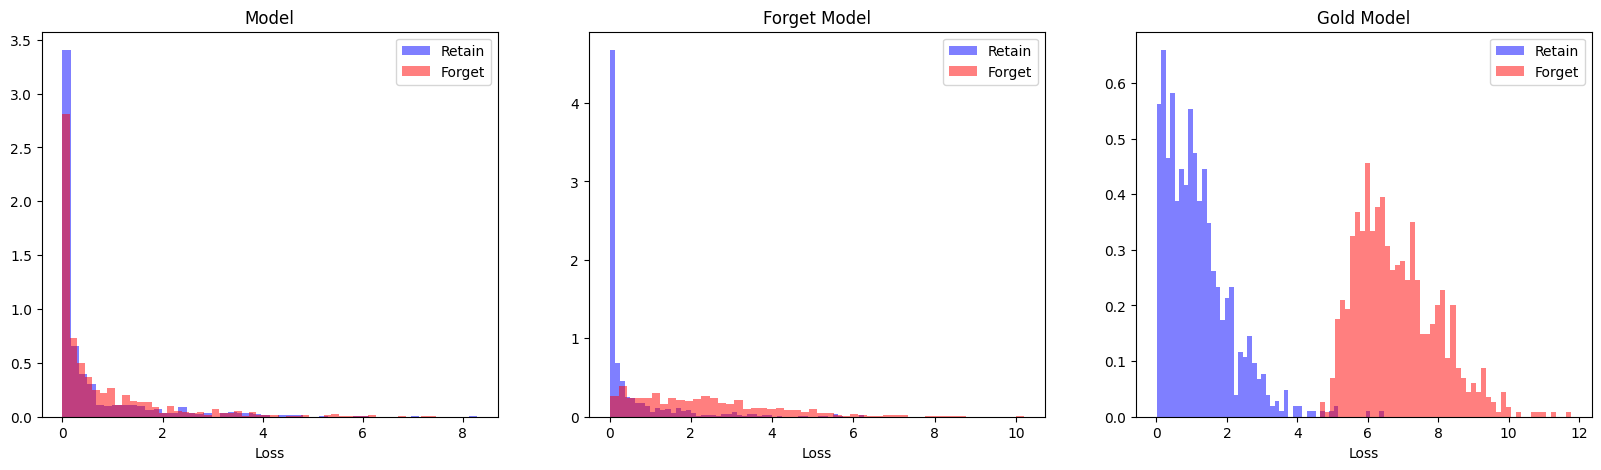

In [ ]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    torch.manual_seed(torch.initial_seed())

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy",
    )

In [ ]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5575


In [ ]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7800


In [ ]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.9969


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A:  The loss plots show how the three models perform on the Retain and Forget sets. The first one (_best\_model_) is highly balanced between the two sets: this is trivial because it has been trained to recognize both. The second one (_foget\_model_) shows that the model performs better on the Retain set, due to the fact that it has been trained to forget the Forget set. Finally the third one (_gold\_model_) shows *very* noticeable differences between the loss on the Retain set and the Forget set.

MIA attacks leverage differences in the loss function to determine if a data point was part of the training set of a given model. As a result of this, we expect higher MIA scores on the models that have very diverse losses for Retain and Forget sets. This is exactly what happens:
- _best\_model_ has similar loss values for both sets, resulting in the MIA model not being able to recognize differences between them (it has an accuracy of $\approx 0.56$ so it's basically just guessing);
- _foget\_model_ has higher differences between the two losses. In general, elements from the Forget set have slightly higher loss values than the ones in the Retain set. This is the reason why the MIA model's performance increases when attacking this model;
- _gold\_model_ has *very* distinct difference between the losses of the two sets. Recognizing if a data point was used in the training set is almost as simple as checking if the loss for that point is greater than $\approx 4.5$. This is why the MIA model performs best, with an accuracy of almost $100\%$.

# 6. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point)

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: We can think about the Cross-Entropy as a measure to compute the *cost* of using one probability distribution to approximate another one. Instead, KL divergence directly measure how much a probability distribution diverge from another one.

Let's analyze the usage of Cross-Entropy in this particular case, starting from the mathematical formulation:

$$ CE(y_{gt}, y_{pred}) = - \sum_{i} y_{gt}[i] \log y_{pred}[i] $$

In our case, $y_{gt} = y_{pred}$, so it is easy to check that the Cross-Entropy correspond to the entropy of the uniform distribution ($H(y_{gt})$), where the entropy is a measure that quantifies the level of uncertainty of a particular probability distribution.

We can discover this value by computing it by hand (either with $CE(y_{gt}, y_{pred})$ or $H(y_{gt})$, since they are equal). By doing so, we obtain:

$$ CE(y_{gt}, y_{pred}) = −(0.25 \times \log(0.25) + 0.25 \times \log(0.25) + 0.25 \times \log(0.25) + 0.25 \times \log(0.25)) = 1.3863 $$

This term express the *cost* of using $y_{pred}$ to approximate $y_{gt}$, and it includes the inherent uncertainty associated with a uniform distribution.

Considering instead the formulation for the KL divergence:

$$ KL(y_{gt}||y_{pred}) = \sum_{i} y_{gt}[i] \log \Biggl(  \frac{y_{gt}[i]}{y_{pred}[i]} \Biggl) $$

we can see how, when $y_{gt} = y_{pred}$, $\log \Bigl(  \frac{y_{gt}[i]}{y_{pred}[i]} \Bigl) = 0$ (because $\log(1) = 0$), so all the summation will be zero.

Given that we want to minimize the loss, it is now clear why we want to use KL instead of CE: a zero value for the loss means that we are perfectly approximating one distribution with the other.

In [ ]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy = - (y_gt @ torch.log(y_pred))
kl_div = y_gt @ torch.log(y_gt / y_pred)

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: Let's consider the generic formula for the Kullback-Leibler divergence:
$$
\begin{align*}
KL(p||q) &= \sum_{x} p(x) \log \Biggl(\frac{p(x)}{q(x)}\Biggl) \\
&= \sum_{x} p(x) [\log(p(x)) - \log(q(x))] \\
&= \sum_{x} p(x) \log (p(x)) - p(x) \log (q(x)) \\
&= \sum_{x} p(x) \log (p(x)) - \sum_{x} p(x) \log (q(x)) \\
&= - H(p) - (-CE(p,q)) \\
&= - H(p) + CE(p,q) \\
&= CE(p,q) - H(p)
\end{align*}
$$
Or said in other words, by rearraging the terms:

$$ CE(p,q) = KL(p||q) + H(p)$$

where $H(p) = - \sum_{x} p(x) \log (p(x)) $ is the *entropy* of a probability distribution, that is, its level of uncertainty.

From this we can understand that the Cross-Entropy not only takes into account the differences between two probability distributions (KL divergence), but also for the inherent uncertainty of the true probability distribution we are trying to approximate.

As it was said above, when $p=q$ then $KL(p||q) = 0$, thus we will obtain $CE(p,q) = H(p)$, meaning that the Cross-Entropy will represent the entropy of the target probability distribution.

In [ ]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0

    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [ ]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)

            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [ ]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"));
another_forget_model.to(device);

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

Epoch [1/10]: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s, loss=1.46]


Epoch [1/10], Average Loss: 1.6866
Validation Loss: 1.4896


Epoch [2/10]: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s, loss=1.16]


Epoch [2/10], Average Loss: 1.2966
Validation Loss: 1.0808


Epoch [3/10]: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, loss=0.93]


Epoch [3/10], Average Loss: 1.0473
Validation Loss: 0.8654


Epoch [4/10]: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, loss=0.81]


Epoch [4/10], Average Loss: 0.8766
Validation Loss: 0.7212


Epoch [5/10]: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.689]


Epoch [5/10], Average Loss: 0.7499
Validation Loss: 0.6159


Epoch [6/10]: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s, loss=0.584]


Epoch [6/10], Average Loss: 0.6486
Validation Loss: 0.5355


Epoch [7/10]: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s, loss=0.524]


Epoch [7/10], Average Loss: 0.5728
Validation Loss: 0.4751


Epoch [8/10]: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, loss=0.471]


Epoch [8/10], Average Loss: 0.5115
Validation Loss: 0.4237


Epoch [9/10]: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s, loss=0.418]


Epoch [9/10], Average Loss: 0.4561
Validation Loss: 0.3784


Epoch [10/10]: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s, loss=0.384]

Epoch [10/10], Average Loss: 0.4142
Validation Loss: 0.3466


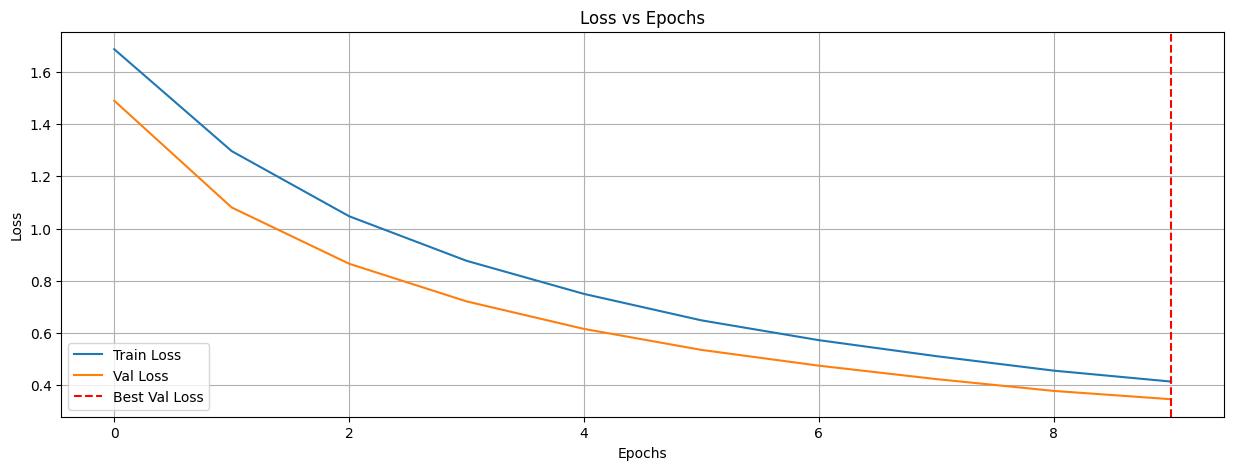

In [ ]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
# calculate accuracy
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

In [ ]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 64.1667
Forget Accuracy: 15.8200
Test Accuracy: 56.5125
Test Retain Accuracy: 61.1944
Test Forget Accuracy: 14.3750


In [ ]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

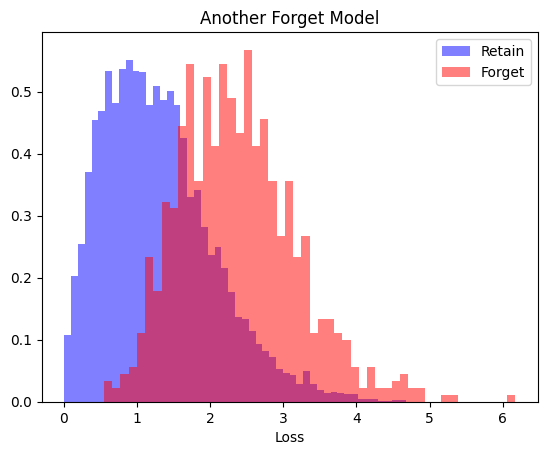

In [ ]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [ ]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.7687


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [ ]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


C:\Users\stefa\AppData\Local\Temp\ipykernel_2704\954954823.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/best_model.pth")


In [ ]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr

# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=pre_embedding_dim,
            edge_in_dim=pre_embedding_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

GraphMetaNetwork(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 64)
    (x_proj): Linear(in_features=192, out_features=64, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 64)
    (edge_attr_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): S

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

### Import Libraries

In [5]:
from numpy import load
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
import openpyxl
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd
import math
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN
from collections import defaultdict
from torch_geometric.utils import subgraph

device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset and Dataloader

The following here presented is the code used to generate the dataset. All the details are inside the report.

From now, we will assume that every file here used (dataset included) was downloaded and moved in the same folder of this notebook. To download the data see in the report.

In [6]:
data_mnist = load('mnist_compressed.npz')

The following is a custom Dataset used to take just a subset of MNIST100

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNIST100Subset(Dataset):
    def __init__(self, data, labels, to_include, transform=None):
        self.filtered_data = []
        self.filtered_labels = []
        conversion = {idx: i for i, idx in enumerate(to_include)}
        for i, label in enumerate(labels):
            if label in to_include:
                self.filtered_data.append(transform(data[i]))
                self.filtered_labels.append(conversion[label])

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        sample = self.filtered_data[idx]
        label = self.filtered_labels[idx]

        return sample, label

The following function was used to compute mean and standard deviations of datasets used to train a CNN and thus creating the weights dataset (the one to be used with th GMN).

In [8]:
def compute_mean_std(dataset):

    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean, std

The code below was used to create the dataset of weights using a very small CNN. All the details are in the report below.

In [9]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 40, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(40, 5),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


def train(train_data, train_labels, model, device, optimizer, scheduler, epochs):
    batch_size = 256
    model.train()
    num_batches = (len(train_data) - 1) // batch_size + 1

    for epoch in range(epochs):
        for i in range(num_batches):
            data = train_data[batch_size * i:batch_size * (i + 1)].to(device)
            target = train_labels[batch_size * i:batch_size * (i + 1)].to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()

def test(test_data, test_labels, model, device):
    batch_size = 256
    model.eval()
    correct = 0

    with torch.no_grad():
        num_batches = (len(test_data) - 1) // batch_size + 1
        for i in range(num_batches):
            data = test_data[batch_size * i:batch_size * (i + 1)].to(device)
            target = test_labels[batch_size * i:batch_size * (i + 1)].to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return 100. * correct / len(test_data)

def train_test_in_memory(dataset_name, base_dir, elems):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(base_dir, exist_ok=True)

    save_dir = os.path.join(base_dir, "model_weights")
    results_file = os.path.join(base_dir, "results.xlsx")

    os.makedirs(save_dir, exist_ok=True)


    data_mean, data_std = compute_mean_std(MNIST100Subset(data_mnist['train_images'], data_mnist['train_labels'], elems, transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((28, 28)),
                                        ])))

    dataset = MNIST100Subset(data_mnist['train_images'], data_mnist['train_labels'], elems, transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((28, 28)),
                                        transforms.Normalize(data_mean, data_std)
                                        ]))

    test_dataset = MNIST100Subset(data_mnist['test_images'], data_mnist['test_labels'], elems, transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((28, 28)),
                                        transforms.Normalize(data_mean, data_std)]))

    train_data = torch.stack(dataset.filtered_data).float()
    train_labels = torch.tensor(dataset.filtered_labels)

    test_data = torch.stack(test_dataset.filtered_data).float()
    test_labels = torch.tensor(test_dataset.filtered_labels)

    all_labels = list(range(5))
    epochs = 30

    for k in tqdm(range(5), desc = "LABELS"):
        for labels_to_remove in tqdm(itertools.combinations(all_labels, k), desc="COMBINATIONS"):
            labels_to_remove = set(labels_to_remove)

            train_mask = ~torch.tensor([label.item() in labels_to_remove for label in train_labels])
            test_mask = ~torch.tensor([label.item() in labels_to_remove for label in test_labels])

            subset_train_data = train_data[train_mask]
            subset_train_labels = train_labels[train_mask]

            subset_test_data = test_data[test_mask]
            subset_test_labels = test_labels[test_mask]

            subset_train_data, subset_train_labels = subset_train_data.to(device), subset_train_labels.to(device)
            subset_test_data, subset_test_labels = subset_test_data.to(device), subset_test_labels.to(device)

            model = TinyCNN().to(device)
            optimizer = optim.Adam(model.parameters(), lr=1e-2)
            scheduler = OneCycleLR(optimizer, max_lr=1e-2,
                                   total_steps=((len(subset_train_data) - 1) // 256 + 1) * epochs,
                                   cycle_momentum=False)

            train(subset_train_data, subset_train_labels, model, device, optimizer, scheduler, epochs)
            test_accuracy_retain = test(subset_test_data, subset_test_labels, model, device)
            test_accuracy_all = test(test_data.to(device), test_labels.to(device), model, device)

            excluded_labels_str = "_".join(map(str, sorted(labels_to_remove)))
            weights_path = os.path.join(save_dir, f"{dataset_name}_excluded_{excluded_labels_str}.pt")
            torch.save(model.state_dict(), weights_path)

            # Record results
            subset_key = f"remove_{k}_labels_{sorted(labels_to_remove)}"
            print(f"{dataset_name}, Subset {subset_key}, Test Accuracy Retain: {test_accuracy_retain:.2f}%, Test Accuracy All: {test_accuracy_all:.2f}%")

            result = {
                "Dataset": dataset_name,
                "Excluded_Labels": sorted(labels_to_remove),
                "Test_Accuracy_Retain": test_accuracy_retain,
                "Test_Accuracy_All": test_accuracy_all,
                "Weights_Path": weights_path
            }

            try:
                workbook = openpyxl.load_workbook(results_file)
                sheet = workbook.active
            except FileNotFoundError:
                workbook = openpyxl.Workbook()
                sheet = workbook.active

                sheet.append(["Dataset", "Excluded_Labels", "Test_Accuracy_Retain", "Test_Accuracy_All", "Weights_Path"])

            sheet.append([
                result["Dataset"],
                ', '.join([str(label) for label in result["Excluded_Labels"]]),
                result["Test_Accuracy_Retain"],
                result["Test_Accuracy_All"],
                result["Weights_Path"]
            ])

            workbook.save(results_file)
            workbook.close()

In [ ]:
N = list(range(100))
random.shuffle(N)

for i in range(0, 100, 5):
    curr_elems = N[i:i + 5]
    curr_name = '-'.join(str(i) for i in curr_elems)
    train_test_in_memory(curr_name, "dataset", curr_elems)

COMBINATIONS: 1it [00:01,  1.64s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:06,  1.65s/it]

98-38-51-31-67, Subset remove_0_labels_[], Test Accuracy Retain: 94.89%, Test Accuracy All: 94.89%


98-38-51-31-67, Subset remove_1_labels_[0], Test Accuracy Retain: 94.71%, Test Accuracy All: 73.87%


98-38-51-31-67, Subset remove_1_labels_[1], Test Accuracy Retain: 90.53%, Test Accuracy All: 73.28%


98-38-51-31-67, Subset remove_1_labels_[2], Test Accuracy Retain: 95.52%, Test Accuracy All: 75.44%


98-38-51-31-67, Subset remove_1_labels_[3], Test Accuracy Retain: 94.12%, Test Accuracy All: 75.44%


COMBINATIONS: 5it [00:03,  1.31it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

98-38-51-31-67, Subset remove_1_labels_[4], Test Accuracy Retain: 89.21%, Test Accuracy All: 73.08%


98-38-51-31-67, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 88.33%, Test Accuracy All: 52.06%


98-38-51-31-67, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 97.93%, Test Accuracy All: 55.80%


98-38-51-31-67, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 95.61%, Test Accuracy All: 55.60%


98-38-51-31-67, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 82.95%, Test Accuracy All: 49.71%


98-38-51-31-67, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 99.02%, Test Accuracy All: 59.33%


98-38-51-31-67, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 98.39%, Test Accuracy All: 60.12%


98-38-51-31-67, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 89.38%, Test Accuracy All: 56.19%


98-38-51-31-67, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 93.69%, Test Accuracy All: 55.40%


98-38-51-31-67, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 90.00%, Test Accuracy All: 54.81%


COMBINATIONS: 10it [00:06,  1.59it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.46s/it]

98-38-51-31-67, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 94.30%, Test Accuracy All: 58.55%


98-38-51-31-67, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 96.89%, Test Accuracy All: 36.74%


98-38-51-31-67, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 94.97%, Test Accuracy All: 37.13%


98-38-51-31-67, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 89.90%, Test Accuracy All: 36.74%


98-38-51-31-67, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 97.88%, Test Accuracy All: 36.35%


98-38-51-31-67, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 97.47%, Test Accuracy All: 37.92%


98-38-51-31-67, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 96.57%, Test Accuracy All: 38.70%


98-38-51-31-67, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 98.53%, Test Accuracy All: 39.49%


98-38-51-31-67, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.06%, Test Accuracy All: 41.45%


98-38-51-31-67, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 99.54%, Test Accuracy All: 42.83%


COMBINATIONS: 10it [00:04,  2.20it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.49s/it]

98-38-51-31-67, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 92.34%, Test Accuracy All: 37.92%


98-38-51-31-67, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.07%


98-38-51-31-67, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.84%


98-38-51-31-67, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.02%


98-38-51-31-67, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.06%


COMBINATIONS: 5it [00:01,  3.49it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

98-38-51-31-67, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.00%



COMBINATIONS: 1it [00:01,  1.15s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.15s/it]

12-23-27-33-80, Subset remove_0_labels_[], Test Accuracy Retain: 93.39%, Test Accuracy All: 93.39%


12-23-27-33-80, Subset remove_1_labels_[0], Test Accuracy Retain: 91.32%, Test Accuracy All: 71.60%


12-23-27-33-80, Subset remove_1_labels_[1], Test Accuracy Retain: 98.04%, Test Accuracy All: 78.02%


12-23-27-33-80, Subset remove_1_labels_[2], Test Accuracy Retain: 90.52%, Test Accuracy All: 70.62%


12-23-27-33-80, Subset remove_1_labels_[3], Test Accuracy Retain: 92.74%, Test Accuracy All: 74.51%


COMBINATIONS: 5it [00:03,  1.27it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

12-23-27-33-80, Subset remove_1_labels_[4], Test Accuracy Retain: 91.86%, Test Accuracy All: 76.85%


12-23-27-33-80, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 98.66%, Test Accuracy All: 57.20%


12-23-27-33-80, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 88.62%, Test Accuracy All: 50.00%


12-23-27-33-80, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 90.73%, Test Accuracy All: 53.31%


12-23-27-33-80, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 83.39%, Test Accuracy All: 51.75%


12-23-27-33-80, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 98.65%, Test Accuracy All: 56.81%


12-23-27-33-80, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.10%, Test Accuracy All: 57.59%


12-23-27-33-80, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.23%, Test Accuracy All: 61.48%


12-23-27-33-80, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 97.33%, Test Accuracy All: 56.81%


12-23-27-33-80, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 85.49%, Test Accuracy All: 52.72%


COMBINATIONS: 10it [00:06,  1.62it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.35s/it]

12-23-27-33-80, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 92.40%, Test Accuracy All: 59.14%


12-23-27-33-80, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 97.84%, Test Accuracy All: 35.21%


12-23-27-33-80, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 98.48%, Test Accuracy All: 37.74%


12-23-27-33-80, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 92.52%, Test Accuracy All: 38.52%


12-23-27-33-80, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 97.88%, Test Accuracy All: 35.99%


12-23-27-33-80, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 81.07%, Test Accuracy All: 32.49%


12-23-27-33-80, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 87.16%, Test Accuracy All: 36.96%


12-23-27-33-80, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 96.92%, Test Accuracy All: 36.77%


12-23-27-33-80, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 98.11%, Test Accuracy All: 40.47%


12-23-27-33-80, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 98.21%, Test Accuracy All: 42.80%


COMBINATIONS: 10it [00:04,  2.23it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.41s/it]

12-23-27-33-80, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 97.69%, Test Accuracy All: 41.05%


12-23-27-33-80, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.34%


12-23-27-33-80, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.65%


12-23-27-33-80, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.98%


12-23-27-33-80, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.43%


COMBINATIONS: 5it [00:01,  3.64it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

12-23-27-33-80, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.60%



COMBINATIONS: 1it [00:01,  1.05s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.05s/it]

84-78-79-43-83, Subset remove_0_labels_[], Test Accuracy Retain: 91.04%, Test Accuracy All: 91.04%


84-78-79-43-83, Subset remove_1_labels_[0], Test Accuracy Retain: 89.49%, Test Accuracy All: 70.79%


84-78-79-43-83, Subset remove_1_labels_[1], Test Accuracy Retain: 95.71%, Test Accuracy All: 76.12%


84-78-79-43-83, Subset remove_1_labels_[2], Test Accuracy Retain: 90.14%, Test Accuracy All: 70.15%


84-78-79-43-83, Subset remove_1_labels_[3], Test Accuracy Retain: 91.60%, Test Accuracy All: 74.41%


COMBINATIONS: 5it [00:03,  1.28it/s]
LABELS:  40%|████      | 2/5 [00:04<00:08,  2.74s/it]

84-78-79-43-83, Subset remove_1_labels_[4], Test Accuracy Retain: 83.68%, Test Accuracy All: 68.87%


84-78-79-43-83, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 91.64%, Test Accuracy All: 53.73%


84-78-79-43-83, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 89.51%, Test Accuracy All: 50.96%


84-78-79-43-83, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 86.57%, Test Accuracy All: 52.24%


84-78-79-43-83, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 87.85%, Test Accuracy All: 53.94%


84-78-79-43-83, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 94.42%, Test Accuracy All: 54.16%


84-78-79-43-83, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 91.93%, Test Accuracy All: 55.86%


84-78-79-43-83, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 93.79%, Test Accuracy All: 58.00%


84-78-79-43-83, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 89.53%, Test Accuracy All: 52.88%


84-78-79-43-83, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 92.20%, Test Accuracy All: 55.44%


COMBINATIONS: 10it [00:05,  1.70it/s]
LABELS:  60%|██████    | 3/5 [00:10<00:08,  4.17s/it]

84-78-79-43-83, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 81.54%, Test Accuracy All: 51.81%


84-78-79-43-83, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 88.30%, Test Accuracy All: 32.20%


84-78-79-43-83, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 96.79%, Test Accuracy All: 38.59%


84-78-79-43-83, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 92.71%, Test Accuracy All: 37.95%


84-78-79-43-83, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 89.39%, Test Accuracy All: 34.12%


84-78-79-43-83, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 91.30%, Test Accuracy All: 35.82%


84-78-79-43-83, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 74.00%, Test Accuracy All: 31.56%


84-78-79-43-83, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 92.82%, Test Accuracy All: 35.82%


84-78-79-43-83, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 95.16%, Test Accuracy All: 37.74%


84-78-79-43-83, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 93.07%, Test Accuracy All: 40.09%


COMBINATIONS: 10it [00:04,  2.33it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.22s/it]

84-78-79-43-83, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 95.36%, Test Accuracy All: 39.45%


84-78-79-43-83, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.70%


84-78-79-43-83, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.76%


84-78-79-43-83, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.17%


84-78-79-43-83, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.47%


COMBINATIONS: 5it [00:01,  3.39it/s]
LABELS: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

84-78-79-43-83, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.90%



COMBINATIONS: 1it [00:01,  1.22s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.22s/it]

21-74-41-93-15, Subset remove_0_labels_[], Test Accuracy Retain: 97.77%, Test Accuracy All: 97.77%


21-74-41-93-15, Subset remove_1_labels_[0], Test Accuracy Retain: 98.82%, Test Accuracy All: 78.03%


21-74-41-93-15, Subset remove_1_labels_[1], Test Accuracy Retain: 97.27%, Test Accuracy All: 79.52%


21-74-41-93-15, Subset remove_1_labels_[2], Test Accuracy Retain: 97.10%, Test Accuracy All: 74.86%


21-74-41-93-15, Subset remove_1_labels_[3], Test Accuracy Retain: 96.77%, Test Accuracy All: 78.21%


COMBINATIONS: 5it [00:04,  1.16it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.05s/it]

21-74-41-93-15, Subset remove_1_labels_[4], Test Accuracy Retain: 96.34%, Test Accuracy All: 78.40%


21-74-41-93-15, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 95.40%, Test Accuracy All: 57.91%


21-74-41-93-15, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 96.68%, Test Accuracy All: 54.19%


21-74-41-93-15, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 97.51%, Test Accuracy All: 58.29%


21-74-41-93-15, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 97.53%, Test Accuracy All: 58.85%


21-74-41-93-15, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 97.15%, Test Accuracy All: 57.17%


21-74-41-93-15, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.13%, Test Accuracy All: 60.15%


21-74-41-93-15, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 95.87%, Test Accuracy All: 60.52%


21-74-41-93-15, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 98.39%, Test Accuracy All: 56.98%


21-74-41-93-15, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 96.18%, Test Accuracy All: 56.24%


COMBINATIONS: 10it [00:06,  1.54it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.63s/it]

21-74-41-93-15, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 96.71%, Test Accuracy All: 60.15%


21-74-41-93-15, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 98.52%, Test Accuracy All: 37.24%


21-74-41-93-15, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 98.65%, Test Accuracy All: 40.97%


21-74-41-93-15, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 97.79%, Test Accuracy All: 41.15%


21-74-41-93-15, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 92.42%, Test Accuracy All: 34.08%


21-74-41-93-15, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 96.02%, Test Accuracy All: 35.94%


21-74-41-93-15, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 99.10%, Test Accuracy All: 40.78%


21-74-41-93-15, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 98.12%, Test Accuracy All: 38.92%


21-74-41-93-15, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.07%, Test Accuracy All: 39.85%


21-74-41-93-15, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 94.92%, Test Accuracy All: 41.71%


COMBINATIONS: 10it [00:04,  2.06it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.72s/it]

21-74-41-93-15, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.05%, Test Accuracy All: 38.92%


21-74-41-93-15, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.62%


21-74-41-93-15, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.18%


21-74-41-93-15, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.91%


21-74-41-93-15, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.25%


COMBINATIONS: 5it [00:01,  3.24it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

21-74-41-93-15, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.04%



COMBINATIONS: 1it [00:01,  1.13s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

14-4-34-60-69, Subset remove_0_labels_[], Test Accuracy Retain: 93.65%, Test Accuracy All: 93.65%


14-4-34-60-69, Subset remove_1_labels_[0], Test Accuracy Retain: 94.84%, Test Accuracy All: 76.37%


14-4-34-60-69, Subset remove_1_labels_[1], Test Accuracy Retain: 92.93%, Test Accuracy All: 77.68%


14-4-34-60-69, Subset remove_1_labels_[2], Test Accuracy Retain: 90.48%, Test Accuracy All: 70.68%


14-4-34-60-69, Subset remove_1_labels_[3], Test Accuracy Retain: 94.94%, Test Accuracy All: 73.96%


COMBINATIONS: 5it [00:03,  1.26it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.80s/it]

14-4-34-60-69, Subset remove_1_labels_[4], Test Accuracy Retain: 94.79%, Test Accuracy All: 75.71%


14-4-34-60-69, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 87.37%, Test Accuracy All: 56.02%


14-4-34-60-69, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 83.21%, Test Accuracy All: 48.80%


14-4-34-60-69, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 86.52%, Test Accuracy All: 50.55%


14-4-34-60-69, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 89.13%, Test Accuracy All: 53.83%


14-4-34-60-69, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 95.39%, Test Accuracy All: 58.86%


14-4-34-60-69, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 94.31%, Test Accuracy All: 57.99%


14-4-34-60-69, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.59%, Test Accuracy All: 61.93%


14-4-34-60-69, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 95.70%, Test Accuracy All: 53.61%


14-4-34-60-69, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 89.06%, Test Accuracy All: 51.64%


COMBINATIONS: 10it [00:06,  1.62it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.34s/it]

14-4-34-60-69, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 95.08%, Test Accuracy All: 54.92%


14-4-34-60-69, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 88.08%, Test Accuracy All: 37.20%


14-4-34-60-69, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 84.38%, Test Accuracy All: 35.45%


14-4-34-60-69, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 98.01%, Test Accuracy All: 43.11%


14-4-34-60-69, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 88.02%, Test Accuracy All: 32.17%


14-4-34-60-69, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 82.39%, Test Accuracy All: 31.73%


14-4-34-60-69, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 96.57%, Test Accuracy All: 36.98%


14-4-34-60-69, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 99.45%, Test Accuracy All: 39.39%


14-4-34-60-69, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 97.37%, Test Accuracy All: 40.48%


14-4-34-60-69, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 96.83%, Test Accuracy All: 40.04%


COMBINATIONS: 10it [00:04,  2.20it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.42s/it]

14-4-34-60-69, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 95.12%, Test Accuracy All: 34.14%


14-4-34-60-69, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.13%


14-4-34-60-69, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.10%


14-4-34-60-69, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.88%


14-4-34-60-69, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.41%


COMBINATIONS: 5it [00:01,  3.29it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

14-4-34-60-69, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.47%



COMBINATIONS: 1it [00:01,  1.07s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.08s/it]

75-11-54-52-56, Subset remove_0_labels_[], Test Accuracy Retain: 92.40%, Test Accuracy All: 92.40%


75-11-54-52-56, Subset remove_1_labels_[0], Test Accuracy Retain: 88.08%, Test Accuracy All: 69.82%


75-11-54-52-56, Subset remove_1_labels_[1], Test Accuracy Retain: 85.35%, Test Accuracy All: 62.22%


75-11-54-52-56, Subset remove_1_labels_[2], Test Accuracy Retain: 95.01%, Test Accuracy All: 78.23%


75-11-54-52-56, Subset remove_1_labels_[3], Test Accuracy Retain: 93.20%, Test Accuracy All: 75.98%


COMBINATIONS: 5it [00:03,  1.28it/s]
LABELS:  40%|████      | 2/5 [00:04<00:08,  2.74s/it]

75-11-54-52-56, Subset remove_1_labels_[4], Test Accuracy Retain: 95.11%, Test Accuracy All: 79.88%


75-11-54-52-56, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 72.05%, Test Accuracy All: 37.58%


75-11-54-52-56, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 91.67%, Test Accuracy All: 56.47%


75-11-54-52-56, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 92.57%, Test Accuracy All: 56.26%


75-11-54-52-56, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 89.94%, Test Accuracy All: 56.88%


75-11-54-52-56, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 86.99%, Test Accuracy All: 48.05%


75-11-54-52-56, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 80.00%, Test Accuracy All: 43.53%


75-11-54-52-56, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 81.95%, Test Accuracy All: 46.61%


75-11-54-52-56, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 99.36%, Test Accuracy All: 63.45%


75-11-54-52-56, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 97.21%, Test Accuracy All: 64.48%


COMBINATIONS: 10it [00:06,  1.60it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.34s/it]

75-11-54-52-56, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 97.18%, Test Accuracy All: 63.66%


75-11-54-52-56, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 77.98%, Test Accuracy All: 26.90%


75-11-54-52-56, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 85.37%, Test Accuracy All: 28.75%


75-11-54-52-56, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 85.23%, Test Accuracy All: 30.80%


75-11-54-52-56, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 43.12%


75-11-54-52-56, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 45.59%


75-11-54-52-56, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 44.76%


75-11-54-52-56, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 94.41%, Test Accuracy All: 34.70%


75-11-54-52-56, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 89.01%, Test Accuracy All: 34.91%


75-11-54-52-56, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 87.70%, Test Accuracy All: 33.68%


COMBINATIONS: 10it [00:04,  2.15it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.46s/it]

75-11-54-52-56, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.57%, Test Accuracy All: 47.64%


75-11-54-52-56, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.02%


75-11-54-52-56, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.48%


75-11-54-52-56, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.66%


75-11-54-52-56, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 27.10%


COMBINATIONS: 5it [00:01,  3.42it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

75-11-54-52-56, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.74%



COMBINATIONS: 1it [00:01,  1.11s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.11s/it]

47-64-82-65-71, Subset remove_0_labels_[], Test Accuracy Retain: 95.41%, Test Accuracy All: 95.41%


47-64-82-65-71, Subset remove_1_labels_[0], Test Accuracy Retain: 93.98%, Test Accuracy All: 77.84%


47-64-82-65-71, Subset remove_1_labels_[1], Test Accuracy Retain: 90.33%, Test Accuracy All: 70.86%


47-64-82-65-71, Subset remove_1_labels_[2], Test Accuracy Retain: 93.65%, Test Accuracy All: 73.65%


47-64-82-65-71, Subset remove_1_labels_[3], Test Accuracy Retain: 95.68%, Test Accuracy All: 79.64%


COMBINATIONS: 5it [00:04,  1.20it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

47-64-82-65-71, Subset remove_1_labels_[4], Test Accuracy Retain: 91.95%, Test Accuracy All: 70.66%


47-64-82-65-71, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 91.21%, Test Accuracy All: 55.89%


47-64-82-65-71, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 95.13%, Test Accuracy All: 58.48%


47-64-82-65-71, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 97.28%, Test Accuracy All: 64.27%


47-64-82-65-71, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 86.62%, Test Accuracy All: 51.70%


47-64-82-65-71, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 95.10%, Test Accuracy All: 54.29%


47-64-82-65-71, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.44%, Test Accuracy All: 59.48%


47-64-82-65-71, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 84.12%, Test Accuracy All: 46.51%


47-64-82-65-71, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 97.10%, Test Accuracy All: 60.08%


47-64-82-65-71, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 92.81%, Test Accuracy All: 51.50%


COMBINATIONS: 10it [00:06,  1.60it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.43s/it]

47-64-82-65-71, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 96.68%, Test Accuracy All: 58.08%


47-64-82-65-71, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 99.50%, Test Accuracy All: 39.72%


47-64-82-65-71, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 99.55%, Test Accuracy All: 44.31%


47-64-82-65-71, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 79.06%, Test Accuracy All: 30.14%


47-64-82-65-71, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 99.11%, Test Accuracy All: 44.31%


47-64-82-65-71, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 92.19%, Test Accuracy All: 35.33%


47-64-82-65-71, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 92.09%, Test Accuracy All: 39.52%


47-64-82-65-71, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 95.05%, Test Accuracy All: 38.32%


47-64-82-65-71, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 97.65%, Test Accuracy All: 33.13%


47-64-82-65-71, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 90.67%, Test Accuracy All: 34.93%


COMBINATIONS: 10it [00:04,  2.20it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.48s/it]

47-64-82-65-71, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 88.14%, Test Accuracy All: 34.13%


47-64-82-65-71, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 23.15%


47-64-82-65-71, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.77%


47-64-82-65-71, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.36%


47-64-82-65-71, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.56%


COMBINATIONS: 5it [00:01,  3.17it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

47-64-82-65-71, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.17%



COMBINATIONS: 1it [00:01,  1.17s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.18s/it]

20-17-92-81-95, Subset remove_0_labels_[], Test Accuracy Retain: 93.81%, Test Accuracy All: 93.81%


20-17-92-81-95, Subset remove_1_labels_[0], Test Accuracy Retain: 92.20%, Test Accuracy All: 73.11%


20-17-92-81-95, Subset remove_1_labels_[1], Test Accuracy Retain: 92.58%, Test Accuracy All: 70.02%


20-17-92-81-95, Subset remove_1_labels_[2], Test Accuracy Retain: 96.94%, Test Accuracy All: 79.69%


20-17-92-81-95, Subset remove_1_labels_[3], Test Accuracy Retain: 88.80%, Test Accuracy All: 67.50%


COMBINATIONS: 5it [00:04,  1.18it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

20-17-92-81-95, Subset remove_1_labels_[4], Test Accuracy Retain: 96.88%, Test Accuracy All: 84.14%


20-17-92-81-95, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 91.90%, Test Accuracy All: 50.48%


20-17-92-81-95, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 97.48%, Test Accuracy All: 59.96%


20-17-92-81-95, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 90.56%, Test Accuracy All: 50.10%


20-17-92-81-95, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 96.78%, Test Accuracy All: 64.02%


20-17-92-81-95, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 96.99%, Test Accuracy All: 56.09%


20-17-92-81-95, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 80.52%, Test Accuracy All: 41.59%


20-17-92-81-95, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 95.05%, Test Accuracy All: 59.38%


20-17-92-81-95, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 92.69%, Test Accuracy All: 53.97%


20-17-92-81-95, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 98.04%, Test Accuracy All: 67.70%


COMBINATIONS: 10it [00:06,  1.53it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:09,  4.60s/it]

20-17-92-81-95, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 90.46%, Test Accuracy All: 56.87%


20-17-92-81-95, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 98.44%, Test Accuracy All: 36.56%


20-17-92-81-95, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 84.38%, Test Accuracy All: 26.11%


20-17-92-81-95, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 99.07%, Test Accuracy All: 41.39%


20-17-92-81-95, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 98.45%, Test Accuracy All: 36.94%


20-17-92-81-95, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 97.60%, Test Accuracy All: 47.20%


20-17-92-81-95, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 98.62%, Test Accuracy All: 41.59%


20-17-92-81-95, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 98.86%, Test Accuracy All: 33.46%


20-17-92-81-95, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 44.68%


20-17-92-81-95, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 85.93%, Test Accuracy All: 33.08%


COMBINATIONS: 10it [00:04,  2.10it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.67s/it]

20-17-92-81-95, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.57%, Test Accuracy All: 44.87%


20-17-92-81-95, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 13.15%


20-17-92-81-95, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 23.98%


20-17-92-81-95, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.79%


20-17-92-81-95, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 24.37%


COMBINATIONS: 5it [00:01,  2.96it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]

20-17-92-81-95, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.70%



COMBINATIONS: 1it [00:01,  1.28s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:05,  1.29s/it]

39-22-1-91-68, Subset remove_0_labels_[], Test Accuracy Retain: 97.62%, Test Accuracy All: 97.62%


39-22-1-91-68, Subset remove_1_labels_[0], Test Accuracy Retain: 96.00%, Test Accuracy All: 79.12%


39-22-1-91-68, Subset remove_1_labels_[1], Test Accuracy Retain: 96.59%, Test Accuracy All: 72.53%


39-22-1-91-68, Subset remove_1_labels_[2], Test Accuracy Retain: 98.17%, Test Accuracy All: 78.75%
39-22-1-91-68, Subset remove_1_labels_[3], Test Accuracy Retain: 97.91%, Test Accuracy All: 77.11%


COMBINATIONS: 5it [00:04,  1.15it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.08s/it]

39-22-1-91-68, Subset remove_1_labels_[4], Test Accuracy Retain: 96.93%, Test Accuracy All: 80.95%


39-22-1-91-68, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 95.54%, Test Accuracy All: 54.95%


39-22-1-91-68, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 96.49%, Test Accuracy All: 60.44%


39-22-1-91-68, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 98.50%, Test Accuracy All: 60.26%


39-22-1-91-68, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 96.67%, Test Accuracy All: 63.74%


39-22-1-91-68, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 98.34%, Test Accuracy All: 54.40%


39-22-1-91-68, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 97.28%, Test Accuracy All: 52.38%


39-22-1-91-68, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 95.00%, Test Accuracy All: 55.68%


39-22-1-91-68, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 96.27%, Test Accuracy All: 56.78%


39-22-1-91-68, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 98.85%, Test Accuracy All: 63.00%


COMBINATIONS: 10it [00:06,  1.52it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.67s/it]

39-22-1-91-68, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 99.12%, Test Accuracy All: 61.72%


39-22-1-91-68, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 99.51%, Test Accuracy All: 37.55%


39-22-1-91-68, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 98.48%, Test Accuracy All: 35.71%


39-22-1-91-68, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 94.64%, Test Accuracy All: 38.83%


39-22-1-91-68, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 96.90%, Test Accuracy All: 40.11%


39-22-1-91-68, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 99.60%, Test Accuracy All: 45.97%


39-22-1-91-68, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 99.59%, Test Accuracy All: 44.51%


39-22-1-91-68, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 96.77%, Test Accuracy All: 32.97%


39-22-1-91-68, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.53%, Test Accuracy All: 38.64%


39-22-1-91-68, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 99.51%, Test Accuracy All: 37.18%


COMBINATIONS: 10it [00:04,  2.08it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.72s/it]

39-22-1-91-68, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.57%, Test Accuracy All: 42.31%


39-22-1-91-68, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.48%


39-22-1-91-68, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.25%


39-22-1-91-68, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.78%


39-22-1-91-68, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 24.91%


COMBINATIONS: 5it [00:01,  3.32it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]

39-22-1-91-68, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.58%



COMBINATIONS: 1it [00:01,  1.16s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.17s/it]

26-6-96-42-86, Subset remove_0_labels_[], Test Accuracy Retain: 89.14%, Test Accuracy All: 89.14%


26-6-96-42-86, Subset remove_1_labels_[0], Test Accuracy Retain: 85.67%, Test Accuracy All: 66.30%


26-6-96-42-86, Subset remove_1_labels_[1], Test Accuracy Retain: 91.74%, Test Accuracy All: 73.84%
26-6-96-42-86, Subset remove_1_labels_[2], Test Accuracy Retain: 86.24%, Test Accuracy All: 68.07%


26-6-96-42-86, Subset remove_1_labels_[3], Test Accuracy Retain: 83.47%, Test Accuracy All: 66.08%


COMBINATIONS: 5it [00:03,  1.28it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

26-6-96-42-86, Subset remove_1_labels_[4], Test Accuracy Retain: 92.08%, Test Accuracy All: 77.38%


26-6-96-42-86, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 77.01%, Test Accuracy All: 44.57%


26-6-96-42-86, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 90.55%, Test Accuracy All: 51.00%


26-6-96-42-86, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 83.92%, Test Accuracy All: 47.45%


26-6-96-42-86, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 85.56%, Test Accuracy All: 52.55%


26-6-96-42-86, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 83.96%, Test Accuracy All: 49.89%


26-6-96-42-86, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 85.13%, Test Accuracy All: 50.78%


26-6-96-42-86, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 84.54%, Test Accuracy All: 54.55%


26-6-96-42-86, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 86.64%, Test Accuracy All: 50.33%


26-6-96-42-86, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 89.08%, Test Accuracy All: 56.10%


COMBINATIONS: 10it [00:05,  1.69it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.22s/it]

26-6-96-42-86, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 87.02%, Test Accuracy All: 54.99%


26-6-96-42-86, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 95.78%, Test Accuracy All: 35.25%


26-6-96-42-86, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 78.44%, Test Accuracy All: 29.05%


26-6-96-42-86, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 84.66%, Test Accuracy All: 35.48%


26-6-96-42-86, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 83.75%, Test Accuracy All: 29.71%


26-6-96-42-86, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 93.41%, Test Accuracy All: 37.69%


26-6-96-42-86, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 93.44%, Test Accuracy All: 37.92%


26-6-96-42-86, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 91.95%, Test Accuracy All: 35.48%


26-6-96-42-86, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 82.65%, Test Accuracy All: 35.92%


26-6-96-42-86, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 85.79%, Test Accuracy All: 37.47%


COMBINATIONS: 10it [00:04,  2.27it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.29s/it]

26-6-96-42-86, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 87.89%, Test Accuracy All: 37.03%


26-6-96-42-86, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 15.96%


26-6-96-42-86, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.84%


26-6-96-42-86, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.06%


26-6-96-42-86, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.51%


COMBINATIONS: 5it [00:01,  3.09it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

26-6-96-42-86, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.62%



COMBINATIONS: 1it [00:01,  1.19s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.20s/it]

16-88-36-66-29, Subset remove_0_labels_[], Test Accuracy Retain: 95.83%, Test Accuracy All: 95.83%


16-88-36-66-29, Subset remove_1_labels_[0], Test Accuracy Retain: 96.68%, Test Accuracy All: 75.15%


16-88-36-66-29, Subset remove_1_labels_[1], Test Accuracy Retain: 93.83%, Test Accuracy All: 75.55%


16-88-36-66-29, Subset remove_1_labels_[2], Test Accuracy Retain: 98.23%, Test Accuracy All: 77.34%


16-88-36-66-29, Subset remove_1_labels_[3], Test Accuracy Retain: 97.14%, Test Accuracy All: 80.91%


COMBINATIONS: 5it [00:03,  1.25it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

16-88-36-66-29, Subset remove_1_labels_[4], Test Accuracy Retain: 95.26%, Test Accuracy All: 75.94%


16-88-36-66-29, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 90.10%, Test Accuracy All: 52.49%


16-88-36-66-29, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 98.59%, Test Accuracy All: 55.67%


16-88-36-66-29, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 93.49%, Test Accuracy All: 57.06%


16-88-36-66-29, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 92.39%, Test Accuracy All: 53.08%


16-88-36-66-29, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 97.99%, Test Accuracy All: 58.05%


16-88-36-66-29, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.57%, Test Accuracy All: 61.63%


16-88-36-66-29, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.03%, Test Accuracy All: 58.45%


16-88-36-66-29, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 62.03%


16-88-36-66-29, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 98.30%, Test Accuracy All: 57.46%


COMBINATIONS: 10it [00:06,  1.57it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.45s/it]

16-88-36-66-29, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 98.74%, Test Accuracy All: 62.23%


16-88-36-66-29, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 98.92%, Test Accuracy All: 36.58%


16-88-36-66-29, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 85.17%, Test Accuracy All: 35.39%


16-88-36-66-29, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 88.48%, Test Accuracy All: 33.60%


16-88-36-66-29, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 97.00%, Test Accuracy All: 38.57%


16-88-36-66-29, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 99.45%, Test Accuracy All: 35.98%
16-88-36-66-29, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 99.02%, Test Accuracy All: 40.36%


16-88-36-66-29, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 42.54%


16-88-36-66-29, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 95.41%, Test Accuracy All: 37.18%


16-88-36-66-29, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 98.63%, Test Accuracy All: 42.94%


COMBINATIONS: 10it [00:04,  2.11it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.57s/it]

16-88-36-66-29, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.05%, Test Accuracy All: 41.35%


16-88-36-66-29, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.28%


16-88-36-66-29, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.70%


16-88-36-66-29, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.27%


16-88-36-66-29, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.48%


COMBINATIONS: 5it [00:01,  3.16it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]

16-88-36-66-29, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.27%



COMBINATIONS: 1it [00:01,  1.13s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

72-30-63-24-59, Subset remove_0_labels_[], Test Accuracy Retain: 89.16%, Test Accuracy All: 89.16%


72-30-63-24-59, Subset remove_1_labels_[0], Test Accuracy Retain: 87.63%, Test Accuracy All: 69.53%


72-30-63-24-59, Subset remove_1_labels_[1], Test Accuracy Retain: 87.79%, Test Accuracy All: 70.55%


72-30-63-24-59, Subset remove_1_labels_[2], Test Accuracy Retain: 87.05%, Test Accuracy All: 68.71%


72-30-63-24-59, Subset remove_1_labels_[3], Test Accuracy Retain: 84.65%, Test Accuracy All: 67.69%


COMBINATIONS: 5it [00:03,  1.32it/s]
LABELS:  40%|████      | 2/5 [00:04<00:08,  2.69s/it]

72-30-63-24-59, Subset remove_1_labels_[4], Test Accuracy Retain: 88.69%, Test Accuracy All: 72.19%


72-30-63-24-59, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 80.48%, Test Accuracy All: 48.06%


72-30-63-24-59, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 85.26%, Test Accuracy All: 49.69%


72-30-63-24-59, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 91.38%, Test Accuracy All: 54.19%


72-30-63-24-59, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 87.21%, Test Accuracy All: 52.97%


72-30-63-24-59, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 88.62%, Test Accuracy All: 52.56%


72-30-63-24-59, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 86.44%, Test Accuracy All: 52.15%


72-30-63-24-59, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 88.74%, Test Accuracy All: 54.81%
72-30-63-24-59, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 92.36%, Test Accuracy All: 54.40%


72-30-63-24-59, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 81.02%, Test Accuracy All: 48.88%


COMBINATIONS: 10it [00:06,  1.64it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.24s/it]

72-30-63-24-59, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 89.67%, Test Accuracy All: 55.01%


72-30-63-24-59, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 87.83%, Test Accuracy All: 33.95%


72-30-63-24-59, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 77.32%, Test Accuracy All: 30.67%


72-30-63-24-59, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 87.06%, Test Accuracy All: 35.79%


72-30-63-24-59, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 86.63%, Test Accuracy All: 33.13%


72-30-63-24-59, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 89.18%, Test Accuracy All: 35.38%


72-30-63-24-59, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 91.96%, Test Accuracy All: 37.42%


72-30-63-24-59, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 90.10%, Test Accuracy All: 35.38%


72-30-63-24-59, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 88.44%, Test Accuracy All: 35.99%


72-30-63-24-59, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 96.57%, Test Accuracy All: 40.29%


COMBINATIONS: 10it [00:04,  2.21it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.35s/it]

72-30-63-24-59, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 90.86%, Test Accuracy All: 36.61%


72-30-63-24-59, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.61%


72-30-63-24-59, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.04%


72-30-63-24-59, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.06%


72-30-63-24-59, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.63%


COMBINATIONS: 5it [00:01,  3.17it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

72-30-63-24-59, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.65%



COMBINATIONS: 1it [00:01,  1.15s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.15s/it]

37-55-44-77-89, Subset remove_0_labels_[], Test Accuracy Retain: 97.61%, Test Accuracy All: 97.61%


37-55-44-77-89, Subset remove_1_labels_[0], Test Accuracy Retain: 99.74%, Test Accuracy All: 77.53%


37-55-44-77-89, Subset remove_1_labels_[1], Test Accuracy Retain: 95.54%, Test Accuracy All: 80.91%
37-55-44-77-89, Subset remove_1_labels_[2], Test Accuracy Retain: 94.51%, Test Accuracy All: 75.35%


37-55-44-77-89, Subset remove_1_labels_[3], Test Accuracy Retain: 96.35%, Test Accuracy All: 73.56%


COMBINATIONS: 5it [00:04,  1.21it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

37-55-44-77-89, Subset remove_1_labels_[4], Test Accuracy Retain: 97.80%, Test Accuracy All: 79.72%


37-55-44-77-89, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 96.50%, Test Accuracy All: 60.24%


37-55-44-77-89, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 98.62%, Test Accuracy All: 56.66%


37-55-44-77-89, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 98.90%, Test Accuracy All: 53.48%


37-55-44-77-89, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 99.33%, Test Accuracy All: 58.85%


37-55-44-77-89, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 94.14%, Test Accuracy All: 60.64%


37-55-44-77-89, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.42%, Test Accuracy All: 58.85%


37-55-44-77-89, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.60%, Test Accuracy All: 64.61%


37-55-44-77-89, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 95.04%, Test Accuracy All: 53.28%


37-55-44-77-89, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 92.53%, Test Accuracy All: 56.66%


COMBINATIONS: 10it [00:06,  1.60it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.43s/it]

37-55-44-77-89, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 57.85%


37-55-44-77-89, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 98.58%, Test Accuracy All: 41.55%


37-55-44-77-89, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 99.49%, Test Accuracy All: 38.57%


37-55-44-77-89, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 43.94%


37-55-44-77-89, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 33.80%


37-55-44-77-89, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 98.47%, Test Accuracy All: 38.37%


37-55-44-77-89, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 35.59%


37-55-44-77-89, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 95.12%, Test Accuracy All: 38.77%


37-55-44-77-89, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 93.51%, Test Accuracy All: 42.94%
37-55-44-77-89, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 42.54%


COMBINATIONS: 10it [00:04,  2.11it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.55s/it]

37-55-44-77-89, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 94.18%, Test Accuracy All: 35.39%


37-55-44-77-89, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.49%


37-55-44-77-89, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 23.66%


37-55-44-77-89, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.28%


37-55-44-77-89, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 15.31%


COMBINATIONS: 5it [00:01,  3.29it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

37-55-44-77-89, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.27%



COMBINATIONS: 1it [00:01,  1.11s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.12s/it]

9-70-57-50-32, Subset remove_0_labels_[], Test Accuracy Retain: 93.80%, Test Accuracy All: 93.80%


9-70-57-50-32, Subset remove_1_labels_[0], Test Accuracy Retain: 87.34%, Test Accuracy All: 67.60%


9-70-57-50-32, Subset remove_1_labels_[1], Test Accuracy Retain: 94.47%, Test Accuracy All: 75.20%


9-70-57-50-32, Subset remove_1_labels_[2], Test Accuracy Retain: 89.28%, Test Accuracy All: 71.60%


9-70-57-50-32, Subset remove_1_labels_[3], Test Accuracy Retain: 95.02%, Test Accuracy All: 80.20%


COMBINATIONS: 5it [00:03,  1.31it/s]
LABELS:  40%|████      | 2/5 [00:04<00:08,  2.71s/it]

9-70-57-50-32, Subset remove_1_labels_[4], Test Accuracy Retain: 88.78%, Test Accuracy All: 69.60%


9-70-57-50-32, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 92.98%, Test Accuracy All: 53.00%


9-70-57-50-32, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 91.67%, Test Accuracy All: 52.80%


9-70-57-50-32, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 95.47%, Test Accuracy All: 59.00%


9-70-57-50-32, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 91.04%, Test Accuracy All: 50.80%


9-70-57-50-32, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 95.65%, Test Accuracy All: 57.20%


9-70-57-50-32, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 94.38%, Test Accuracy All: 60.40%


9-70-57-50-32, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 93.10%, Test Accuracy All: 54.00%
9-70-57-50-32, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 95.67%, Test Accuracy All: 61.80%


9-70-57-50-32, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 90.10%, Test Accuracy All: 52.80%


COMBINATIONS: 10it [00:06,  1.62it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.30s/it]

9-70-57-50-32, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 93.31%, Test Accuracy All: 58.60%


9-70-57-50-32, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 93.55%, Test Accuracy All: 34.80%


9-70-57-50-32, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 83.57%, Test Accuracy All: 34.60%


9-70-57-50-32, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 92.09%, Test Accuracy All: 32.60%


9-70-57-50-32, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 98.57%, Test Accuracy All: 41.40%


9-70-57-50-32, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 88.33%, Test Accuracy All: 31.80%


9-70-57-50-32, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 95.52%, Test Accuracy All: 38.40%


9-70-57-50-32, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 97.74%, Test Accuracy All: 43.20%


9-70-57-50-32, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 94.76%, Test Accuracy All: 36.20%


9-70-57-50-32, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 92.92%, Test Accuracy All: 39.40%


COMBINATIONS: 10it [00:04,  2.16it/s]
LABELS:  80%|████████  | 4/5 [00:15<00:04,  4.43s/it]

9-70-57-50-32, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 93.49%, Test Accuracy All: 40.20%


9-70-57-50-32, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.60%


9-70-57-50-32, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 15.60%


9-70-57-50-32, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.80%


9-70-57-50-32, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.40%


COMBINATIONS: 5it [00:01,  3.29it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

9-70-57-50-32, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.60%



LABELS:   0%|          | 0/5 [00:00<?, ?it/s]

94-3-58-40-99, Subset remove_0_labels_[], Test Accuracy Retain: 93.75%, Test Accuracy All: 93.75%


COMBINATIONS: 1it [00:01,  1.32s/it]
LABELS:  20%|██        | 1/5 [00:01<00:05,  1.32s/it]

94-3-58-40-99, Subset remove_1_labels_[0], Test Accuracy Retain: 95.38%, Test Accuracy All: 75.00%


94-3-58-40-99, Subset remove_1_labels_[1], Test Accuracy Retain: 89.25%, Test Accuracy All: 71.98%


94-3-58-40-99, Subset remove_1_labels_[2], Test Accuracy Retain: 88.43%, Test Accuracy All: 73.99%


94-3-58-40-99, Subset remove_1_labels_[3], Test Accuracy Retain: 90.33%, Test Accuracy All: 71.57%


COMBINATIONS: 5it [00:03,  1.29it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

94-3-58-40-99, Subset remove_1_labels_[4], Test Accuracy Retain: 87.05%, Test Accuracy All: 67.74%


94-3-58-40-99, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 95.92%, Test Accuracy All: 56.85%


94-3-58-40-99, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 95.79%, Test Accuracy All: 59.68%


94-3-58-40-99, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 96.52%, Test Accuracy All: 55.85%


94-3-58-40-99, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 95.36%, Test Accuracy All: 53.83%


94-3-58-40-99, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 83.07%, Test Accuracy All: 53.43%


94-3-58-40-99, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 90.91%, Test Accuracy All: 54.44%


94-3-58-40-99, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 94.14%, Test Accuracy All: 55.04%


94-3-58-40-99, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 74.36%, Test Accuracy All: 46.77%


94-3-58-40-99, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 87.54%, Test Accuracy All: 53.83%


COMBINATIONS: 10it [00:06,  1.62it/s]
LABELS:  60%|██████    | 3/5 [00:11<00:08,  4.36s/it]

94-3-58-40-99, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 90.46%, Test Accuracy All: 51.61%


94-3-58-40-99, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 97.65%, Test Accuracy All: 41.94%
94-3-58-40-99, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 94.24%, Test Accuracy All: 36.29%


94-3-58-40-99, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 97.83%, Test Accuracy All: 36.29%


94-3-58-40-99, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 96.60%, Test Accuracy All: 40.12%


94-3-58-40-99, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 96.48%, Test Accuracy All: 38.71%


94-3-58-40-99, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 92.09%, Test Accuracy All: 32.86%


94-3-58-40-99, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 81.94%, Test Accuracy All: 35.69%


94-3-58-40-99, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 80.38%, Test Accuracy All: 33.87%


94-3-58-40-99, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 98.40%, Test Accuracy All: 37.10%


COMBINATIONS: 10it [00:04,  2.07it/s]
LABELS:  80%|████████  | 4/5 [00:16<00:04,  4.55s/it]

94-3-58-40-99, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 92.08%, Test Accuracy All: 37.50%


94-3-58-40-99, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.18%


94-3-58-40-99, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.77%


94-3-58-40-99, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 16.33%


94-3-58-40-99, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.35%


COMBINATIONS: 5it [00:01,  3.17it/s]
LABELS: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

94-3-58-40-99, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 21.37%



COMBINATIONS: 1it [00:01,  1.21s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.22s/it]

62-76-49-97-48, Subset remove_0_labels_[], Test Accuracy Retain: 95.85%, Test Accuracy All: 95.85%


62-76-49-97-48, Subset remove_1_labels_[0], Test Accuracy Retain: 94.17%, Test Accuracy All: 76.68%


62-76-49-97-48, Subset remove_1_labels_[1], Test Accuracy Retain: 94.46%, Test Accuracy All: 77.47%
62-76-49-97-48, Subset remove_1_labels_[2], Test Accuracy Retain: 96.06%, Test Accuracy All: 77.08%


62-76-49-97-48, Subset remove_1_labels_[3], Test Accuracy Retain: 94.50%, Test Accuracy All: 74.70%


COMBINATIONS: 5it [00:04,  1.17it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.04s/it]

62-76-49-97-48, Subset remove_1_labels_[4], Test Accuracy Retain: 96.68%, Test Accuracy All: 74.70%


62-76-49-97-48, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 89.10%, Test Accuracy All: 56.52%


62-76-49-97-48, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 94.87%, Test Accuracy All: 58.50%


62-76-49-97-48, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 90.20%, Test Accuracy All: 54.55%


62-76-49-97-48, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 89.90%, Test Accuracy All: 52.77%


62-76-49-97-48, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 97.46%, Test Accuracy All: 60.67%


62-76-49-97-48, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 85.76%, Test Accuracy All: 52.37%


62-76-49-97-48, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.67%, Test Accuracy All: 57.91%


62-76-49-97-48, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 92.00%, Test Accuracy All: 54.55%


62-76-49-97-48, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 94.50%, Test Accuracy All: 54.35%


COMBINATIONS: 10it [00:06,  1.49it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.72s/it]

62-76-49-97-48, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 91.93%, Test Accuracy All: 51.78%


62-76-49-97-48, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 95.48%, Test Accuracy All: 41.70%


62-76-49-97-48, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 86.05%, Test Accuracy All: 36.56%


62-76-49-97-48, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 93.69%, Test Accuracy All: 38.14%


62-76-49-97-48, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 96.12%, Test Accuracy All: 39.13%
62-76-49-97-48, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 94.92%, Test Accuracy All: 36.96%


62-76-49-97-48, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 90.05%, Test Accuracy All: 33.99%


62-76-49-97-48, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 97.61%, Test Accuracy All: 40.32%


62-76-49-97-48, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.00%, Test Accuracy All: 39.13%


62-76-49-97-48, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 95.36%, Test Accuracy All: 36.56%


COMBINATIONS: 10it [00:04,  2.03it/s]
LABELS:  80%|████████  | 4/5 [00:17<00:04,  4.81s/it]

62-76-49-97-48, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 89.19%, Test Accuracy All: 32.61%


62-76-49-97-48, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.73%


62-76-49-97-48, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.95%


62-76-49-97-48, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.76%


62-76-49-97-48, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.98%


COMBINATIONS: 5it [00:01,  3.05it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]

62-76-49-97-48, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.58%



COMBINATIONS: 1it [00:01,  1.13s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

45-85-53-19-28, Subset remove_0_labels_[], Test Accuracy Retain: 95.14%, Test Accuracy All: 95.14%


45-85-53-19-28, Subset remove_1_labels_[0], Test Accuracy Retain: 92.42%, Test Accuracy All: 76.52%


45-85-53-19-28, Subset remove_1_labels_[1], Test Accuracy Retain: 96.16%, Test Accuracy All: 81.17%


45-85-53-19-28, Subset remove_1_labels_[2], Test Accuracy Retain: 91.30%, Test Accuracy All: 72.27%


45-85-53-19-28, Subset remove_1_labels_[3], Test Accuracy Retain: 88.83%, Test Accuracy All: 69.23%
45-85-53-19-28, Subset remove_1_labels_[4], Test Accuracy Retain: 93.58%, Test Accuracy All: 70.85%


COMBINATIONS: 5it [00:04,  1.17it/s]
LABELS:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

45-85-53-19-28, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 95.48%, Test Accuracy All: 64.17%


45-85-53-19-28, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 86.93%, Test Accuracy All: 53.85%


45-85-53-19-28, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 85.33%, Test Accuracy All: 51.82%


45-85-53-19-28, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 91.00%, Test Accuracy All: 53.24%


45-85-53-19-28, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 94.90%, Test Accuracy All: 60.32%


45-85-53-19-28, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 93.18%, Test Accuracy All: 58.10%


45-85-53-19-28, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 95.96%, Test Accuracy All: 57.69%


45-85-53-19-28, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 80.85%, Test Accuracy All: 46.15%


45-85-53-19-28, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 94.46%, Test Accuracy All: 51.82%


COMBINATIONS: 10it [00:06,  1.49it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.68s/it]

45-85-53-19-28, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 88.68%, Test Accuracy All: 47.57%


45-85-53-19-28, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 99.56%, Test Accuracy All: 46.15%


45-85-53-19-28, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 92.83%, Test Accuracy All: 41.90%


45-85-53-19-28, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 42.91%


45-85-53-19-28, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 72.59%, Test Accuracy All: 28.95%


45-85-53-19-28, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 37.65%
45-85-53-19-28, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 86.67%, Test Accuracy All: 31.58%


45-85-53-19-28, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 88.29%, Test Accuracy All: 36.64%


45-85-53-19-28, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.48%, Test Accuracy All: 39.07%


45-85-53-19-28, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 95.74%, Test Accuracy All: 36.44%


COMBINATIONS: 10it [00:04,  2.00it/s]
LABELS:  80%|████████  | 4/5 [00:17<00:04,  4.81s/it]

45-85-53-19-28, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 87.04%, Test Accuracy All: 28.54%


45-85-53-19-28, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 24.29%


45-85-53-19-28, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.06%


45-85-53-19-28, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.85%


45-85-53-19-28, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 15.59%


COMBINATIONS: 5it [00:01,  2.99it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

45-85-53-19-28, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.21%



COMBINATIONS: 1it [00:01,  1.30s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:05,  1.30s/it]

61-18-90-73-25, Subset remove_0_labels_[], Test Accuracy Retain: 97.87%, Test Accuracy All: 97.87%


61-18-90-73-25, Subset remove_1_labels_[0], Test Accuracy Retain: 95.92%, Test Accuracy All: 77.37%


61-18-90-73-25, Subset remove_1_labels_[1], Test Accuracy Retain: 96.02%, Test Accuracy All: 74.66%


61-18-90-73-25, Subset remove_1_labels_[2], Test Accuracy Retain: 97.80%, Test Accuracy All: 77.56%


61-18-90-73-25, Subset remove_1_labels_[3], Test Accuracy Retain: 97.81%, Test Accuracy All: 77.76%


COMBINATIONS: 5it [00:04,  1.14it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.12s/it]

61-18-90-73-25, Subset remove_1_labels_[4], Test Accuracy Retain: 96.96%, Test Accuracy All: 80.27%


61-18-90-73-25, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 93.38%, Test Accuracy All: 54.55%


61-18-90-73-25, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 97.10%, Test Accuracy All: 58.22%


61-18-90-73-25, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 96.78%, Test Accuracy All: 58.22%


61-18-90-73-25, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 96.04%, Test Accuracy All: 60.93%


61-18-90-73-25, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 96.95%, Test Accuracy All: 55.32%


61-18-90-73-25, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 98.65%, Test Accuracy All: 56.48%


61-18-90-73-25, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 98.08%, Test Accuracy All: 59.38%


61-18-90-73-25, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 99.34%, Test Accuracy All: 58.41%


61-18-90-73-25, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 98.75%, Test Accuracy All: 61.32%


COMBINATIONS: 10it [00:07,  1.39it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.99s/it]

61-18-90-73-25, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 96.58%, Test Accuracy All: 60.15%


61-18-90-73-25, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 89.74%, Test Accuracy All: 33.85%


61-18-90-73-25, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 96.94%, Test Accuracy All: 36.75%


61-18-90-73-25, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 92.96%, Test Accuracy All: 38.30%


61-18-90-73-25, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 39.46%
61-18-90-73-25, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 99.10%, Test Accuracy All: 42.36%


61-18-90-73-25, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 95.50%, Test Accuracy All: 41.01%


61-18-90-73-25, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 36.56%


61-18-90-73-25, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.51%, Test Accuracy All: 39.65%


61-18-90-73-25, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 40.04%


COMBINATIONS: 10it [00:05,  1.86it/s]
LABELS:  80%|████████  | 4/5 [00:18<00:05,  5.14s/it]

61-18-90-73-25, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 98.60%, Test Accuracy All: 41.01%


61-18-90-73-25, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.21%


61-18-90-73-25, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.50%


61-18-90-73-25, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.70%


61-18-90-73-25, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 22.24%


COMBINATIONS: 5it [00:01,  2.96it/s]
LABELS: 100%|██████████| 5/5 [00:19<00:00,  3.99s/it]

61-18-90-73-25, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 19.34%



COMBINATIONS: 1it [00:01,  1.19s/it]?, ?it/s]
LABELS:  20%|██        | 1/5 [00:01<00:04,  1.19s/it]

13-8-5-35-46, Subset remove_0_labels_[], Test Accuracy Retain: 94.14%, Test Accuracy All: 94.14%


13-8-5-35-46, Subset remove_1_labels_[0], Test Accuracy Retain: 91.14%, Test Accuracy All: 66.46%
13-8-5-35-46, Subset remove_1_labels_[1], Test Accuracy Retain: 97.98%, Test Accuracy All: 78.38%


13-8-5-35-46, Subset remove_1_labels_[2], Test Accuracy Retain: 97.80%, Test Accuracy All: 81.01%


13-8-5-35-46, Subset remove_1_labels_[3], Test Accuracy Retain: 92.33%, Test Accuracy All: 75.35%


COMBINATIONS: 5it [00:04,  1.17it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.00s/it]

13-8-5-35-46, Subset remove_1_labels_[4], Test Accuracy Retain: 93.64%, Test Accuracy All: 77.37%


13-8-5-35-46, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 98.47%, Test Accuracy All: 52.12%


13-8-5-35-46, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 97.10%, Test Accuracy All: 54.14%


13-8-5-35-46, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 87.04%, Test Accuracy All: 47.47%


13-8-5-35-46, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 87.64%, Test Accuracy All: 48.69%


13-8-5-35-46, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 97.11%, Test Accuracy All: 61.01%


13-8-5-35-46, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 96.39%, Test Accuracy All: 59.39%


13-8-5-35-46, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 97.74%, Test Accuracy All: 61.21%


13-8-5-35-46, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 97.81%, Test Accuracy All: 63.03%


13-8-5-35-46, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 97.22%, Test Accuracy All: 63.64%


COMBINATIONS: 10it [00:06,  1.52it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.63s/it]

13-8-5-35-46, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 90.57%, Test Accuracy All: 58.18%


13-8-5-35-46, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 98.31%, Test Accuracy All: 35.15%


13-8-5-35-46, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 97.66%, Test Accuracy All: 33.74%


13-8-5-35-46, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 97.73%, Test Accuracy All: 34.75%


13-8-5-35-46, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 96.22%, Test Accuracy All: 35.96%


13-8-5-35-46, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 97.89%, Test Accuracy All: 37.58%


13-8-5-35-46, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 86.41%, Test Accuracy All: 32.12%


13-8-5-35-46, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 99.09%, Test Accuracy All: 44.04%


13-8-5-35-46, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 96.44%, Test Accuracy All: 43.84%


13-8-5-35-46, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 44.24%


COMBINATIONS: 10it [00:05,  1.94it/s]
LABELS:  80%|████████  | 4/5 [00:17<00:04,  4.85s/it]

13-8-5-35-46, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 98.28%, Test Accuracy All: 46.26%


13-8-5-35-46, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.37%


13-8-5-35-46, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.38%


13-8-5-35-46, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.17%


13-8-5-35-46, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.00%


COMBINATIONS: 5it [00:01,  2.88it/s]
LABELS: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]

13-8-5-35-46, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 27.07%



LABELS:   0%|          | 0/5 [00:00<?, ?it/s]

10-0-87-7-2, Subset remove_0_labels_[], Test Accuracy Retain: 95.28%, Test Accuracy All: 95.28%


COMBINATIONS: 1it [00:01,  1.40s/it]
LABELS:  20%|██        | 1/5 [00:01<00:05,  1.40s/it]

10-0-87-7-2, Subset remove_1_labels_[0], Test Accuracy Retain: 91.81%, Test Accuracy All: 72.69%


10-0-87-7-2, Subset remove_1_labels_[1], Test Accuracy Retain: 94.67%, Test Accuracy All: 76.82%


10-0-87-7-2, Subset remove_1_labels_[2], Test Accuracy Retain: 91.26%, Test Accuracy All: 69.74%


10-0-87-7-2, Subset remove_1_labels_[3], Test Accuracy Retain: 93.95%, Test Accuracy All: 76.23%


COMBINATIONS: 5it [00:04,  1.17it/s]
LABELS:  40%|████      | 2/5 [00:05<00:09,  3.10s/it]

10-0-87-7-2, Subset remove_1_labels_[4], Test Accuracy Retain: 93.30%, Test Accuracy All: 76.62%


10-0-87-7-2, Subset remove_2_labels_[0, 1], Test Accuracy Retain: 85.99%, Test Accuracy All: 51.87%


10-0-87-7-2, Subset remove_2_labels_[0, 2], Test Accuracy Retain: 89.75%, Test Accuracy All: 49.90%


10-0-87-7-2, Subset remove_2_labels_[0, 3], Test Accuracy Retain: 89.90%, Test Accuracy All: 54.22%


10-0-87-7-2, Subset remove_2_labels_[0, 4], Test Accuracy Retain: 92.31%, Test Accuracy All: 56.58%


10-0-87-7-2, Subset remove_2_labels_[1, 2], Test Accuracy Retain: 94.54%, Test Accuracy All: 54.42%


10-0-87-7-2, Subset remove_2_labels_[1, 3], Test Accuracy Retain: 97.16%, Test Accuracy All: 60.51%


10-0-87-7-2, Subset remove_2_labels_[1, 4], Test Accuracy Retain: 92.86%, Test Accuracy All: 58.74%


10-0-87-7-2, Subset remove_2_labels_[2, 3], Test Accuracy Retain: 93.17%, Test Accuracy All: 53.63%
10-0-87-7-2, Subset remove_2_labels_[2, 4], Test Accuracy Retain: 97.32%, Test Accuracy All: 56.97%


COMBINATIONS: 10it [00:06,  1.43it/s]
LABELS:  60%|██████    | 3/5 [00:12<00:09,  4.87s/it]

10-0-87-7-2, Subset remove_2_labels_[3, 4], Test Accuracy Retain: 97.83%, Test Accuracy All: 61.89%


10-0-87-7-2, Subset remove_3_labels_[0, 1, 2], Test Accuracy Retain: 96.26%, Test Accuracy All: 35.36%


10-0-87-7-2, Subset remove_3_labels_[0, 1, 3], Test Accuracy Retain: 93.36%, Test Accuracy All: 38.70%


10-0-87-7-2, Subset remove_3_labels_[0, 1, 4], Test Accuracy Retain: 83.33%, Test Accuracy All: 35.36%


10-0-87-7-2, Subset remove_3_labels_[0, 2, 3], Test Accuracy Retain: 89.30%, Test Accuracy All: 32.81%


10-0-87-7-2, Subset remove_3_labels_[0, 2, 4], Test Accuracy Retain: 96.35%, Test Accuracy All: 36.35%


10-0-87-7-2, Subset remove_3_labels_[0, 3, 4], Test Accuracy Retain: 97.69%, Test Accuracy All: 41.45%


10-0-87-7-2, Subset remove_3_labels_[1, 2, 3], Test Accuracy Retain: 99.49%, Test Accuracy All: 38.51%


10-0-87-7-2, Subset remove_3_labels_[1, 2, 4], Test Accuracy Retain: 99.50%, Test Accuracy All: 39.49%


10-0-87-7-2, Subset remove_3_labels_[1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 44.40%


COMBINATIONS: 10it [00:04,  2.02it/s]
LABELS:  80%|████████  | 4/5 [00:17<00:04,  4.91s/it]

10-0-87-7-2, Subset remove_3_labels_[2, 3, 4], Test Accuracy Retain: 99.01%, Test Accuracy All: 39.29%


10-0-87-7-2, Subset remove_4_labels_[0, 1, 2, 3], Test Accuracy Retain: 100.00%, Test Accuracy All: 17.88%


10-0-87-7-2, Subset remove_4_labels_[0, 1, 2, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.86%
10-0-87-7-2, Subset remove_4_labels_[0, 1, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 23.58%


10-0-87-7-2, Subset remove_4_labels_[0, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 18.86%


COMBINATIONS: 5it [00:01,  2.66it/s]
LABELS: 100%|██████████| 5/5 [00:19<00:00,  3.90s/it]

10-0-87-7-2, Subset remove_4_labels_[1, 2, 3, 4], Test Accuracy Retain: 100.00%, Test Accuracy All: 20.83%


Code to split the dataset into training, validation and test. All the details are in the report below.

In [10]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

assert train_split + test_split + val_split == 1., "Splitting percentages must add to one"

weights_file = "dataset/results.xlsx"
df = pd.read_excel(weights_file ,engine='openpyxl',dtype=object,header=None)
values = df.values.tolist()[1:]

datasets = list(set([data[0] for data in values]))

train_datasets = datasets[:int(len(datasets)*train_split)]
val_datasets = datasets[int(len(datasets)*train_split):int(len(datasets)*train_split) + int(len(datasets)*val_split)]
test_datasets = datasets[int(len(datasets)*train_split) + int(len(datasets)*val_split):]

train_data, val_data, test_data = [], [], []
for data in values:
    if data[0] in train_datasets:
        train_data.append(data)
    elif data[0] in val_datasets:
        val_data.append(data)
    elif data[0] in test_datasets:
        test_data.append(data)

#Very ugly sanity check
d = [train_datasets, val_datasets, test_datasets]
for i in range(3):
    for j in range(i+1, 3):
        assert set(d[i]).intersection(set(d[j])) == set(), "Different splitting should not have elements in common"

This was a utility function used to compute how many weights we were going to reconstruct (that is, how big the TinyCNN model was)

In [11]:
def count_weights(model):
    weights = model.state_dict()
    w = []

    for _, p in weights.items():
      w.append(p.flatten())

    w = torch.cat(w)
    return w.shape

reconstructed_size = count_weights(TinyCNN())

The following custom Dataset was defined to obtain the unrolled weights of the network trained on all the labels, the graph for the CNN, the excluded labels.
If the testing flag is on, then we also return the weights of the model that was trained on all the labels of that subset (just for comparison), the arch to reconstruct the model from the reconstructed weights and the labels identiyfing the subset of MNIST-100 (to test the reconstructed model)

In [24]:
class WeightsDataset(Dataset):
    def __init__(self, weights_dir, values, model, test = False, print_verbose = False, run_locally = False):

        self.weights_dir = weights_dir
        self.model = model

        self.values = values

        if run_locally:
           for data in self.values:
              data[4] = data[4].split("\\" if "\\" in data[4] else "/")[-1].replace('\\','/')

        self.base_models = self.return_trained_all()

        self.test = test
        self.print_verbose = print_verbose

    def __len__(self):
        return len(self.values)

    def encode_excluded_labels(self, excluded_labels):
        if type(excluded_labels) == float: #Used to exclude the first entry that is just the model trained on every label (it contains nan in excluded labels, that is a float)
            return torch.ones(5, dtype=torch.int)

        int_labels = [int(label) for label in excluded_labels.split(",")]
        tensor = torch.ones(5, dtype=torch.int)

        tensor[int_labels] = 0

        return tensor

    def unroll_weights(self, weights):
        w = []

        for _, p in weights.items():
          w.append(p.flatten())

        w = torch.cat(w)
        return w

    def return_trained_all(self):
        to_return = dict()
        for data in self.values:
          if type(data[1]) == float: # it is nan, so no labels were excluded
            path = data[4]
            weights = torch.load(os.path.join(self.weights_dir, path), weights_only=True)
            to_return[data[0]] = weights

        return to_return


    def __getitem__(self, idx):
        data = self.values[idx]

        path = data[4]
        weights = torch.load(os.path.join(self.weights_dir, path), weights_only=True)

        self.model.load_state_dict(self.base_models[data[0]])
        arch = sequential_to_arch(self.model.model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        x = x.float()
        edge_attr = edge_attr.float()

        if self.print_verbose:
          print(f"Excluded labels: {data[1]}")
          print(f"Dataset on which weights were trained: {data[0]}")
        excluded_labels = self.encode_excluded_labels(data[1])

        g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u=torch.zeros(1,1))

        if self.test:
          used_labels = [int(x) for x in data[0].split("-")]
          return self.base_models[data[0]], self.unroll_weights(weights), g_cnn, arch, excluded_labels, used_labels

        return self.unroll_weights(weights), g_cnn, excluded_labels

In [25]:
train_dataset = WeightsDataset("dataset/model_weights", train_data, TinyCNN(), run_locally=True)
val_dataset = WeightsDataset("dataset/model_weights", val_data, TinyCNN(), run_locally=True)
test_dataset = WeightsDataset("dataset/model_weights", test_data, TinyCNN(), run_locally=True, test=True, print_verbose=True)

In [26]:
n_nodes = train_dataset[0][1].x.shape[0]
n_edges = train_dataset[0][1].edge_attr.shape[0]
len_excluded_labels = len(train_dataset[0][2])

We had to define our custom collate_fn because of the *batch graph*. We could have used the Dataloader defined by torch geometric, but we have to return also other things and not only the batched graphs

In [27]:
def collate_fn(batch):
    weights, graphs, excluded_labels = zip(*batch)

    batched_graphs = Batch.from_data_list(graphs)

    batched_weights = torch.stack(weights)

    excluded_labels = torch.stack(excluded_labels)

    return batched_weights, batched_graphs, excluded_labels

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

### Model

The following is the model definition. The architecture is very complex, and it is all detailed inside the report.

In [28]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return x, edge_attr, u

class WeightsReconstructor(nn.Module):
  def __init__(self,
                n_nodes, # Number of nodes for graph in the batch
                n_edges, # Number of edges for graph in the batch
                len_excluded_labels, # Number of excluded labels (5)
                reconstructed_size, # Size of the weights to reconstruct (9125 in our case)
                target_node_dim = 8, # Dimension of all the node features after the convolution on the nodes
                target_edge_dim = 32, # Same but whit the edges
                latent_code_dim = 96, # Latent code dimension of ALL THE NETWORK
                middle_representation_channels = 3): # the latent code is been reshaped in k * 3
    super(WeightsReconstructor, self).__init__()

    # ============ GMN definition ============
    pre_embedding_dim = 3 # Dimension of the node and edge features before the GMN whit a class of gmn pakage
    global_in_dim = 1 # useless
    hidden_dim = 2 # hidden dimention of the GMN embeddings
    node_out_dim = 3 # output dimention of the node embeddings
    edge_out_dim = 3 # output dimention of the edge embeddings
    global_out_dim = 1 # useless
    num_gnn_layers = 2 # number of layers of the GMN
    encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
    mpnn = MPNN(node_in_dim=pre_embedding_dim,
                edge_in_dim=pre_embedding_dim,
                global_in_dim = global_in_dim,
                hidden_dim=hidden_dim,
                node_out_dim= node_out_dim,
                edge_out_dim = edge_out_dim,
                global_out_dim= global_out_dim,
                num_layers=num_gnn_layers,
                reduce='mean')
    self.gmn = GraphMetaNetwork(encoder, mpnn).to(device)


    # ============ Convolutions to reduce dimensionality of edges and nodes features ============

    self.target_node_dim = target_node_dim
    self.target_edge_dim = target_edge_dim

    self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=node_out_dim, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(n_nodes * 32, self.target_node_dim)
        )

    self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=edge_out_dim, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear((n_edges // 8) * 64, self.target_edge_dim)
        )

    # ============ Fully connected layer to project features and excluded labels into latent space ============
    self.reconstructed_size = reconstructed_size
    self.latent_code_dim = latent_code_dim

    self.fc = nn.Linear(target_edge_dim + target_node_dim + len_excluded_labels, self.latent_code_dim)

    # ============ Deconvolutions and final fully connected layer to reconstruct weights from latent code ============

    assert latent_code_dim % middle_representation_channels == 0, "Latent code dimension must be divisible by middle representation channels!"
    self.middle_representation_channels = middle_representation_channels
    self.middle_representation_length = self.latent_code_dim // self.middle_representation_channels

    self.deconv = nn.Sequential(
            nn.ConvTranspose1d(self.middle_representation_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Flatten(start_dim=1),
            nn.Linear(self.middle_representation_length  * 8, self.reconstructed_size)
        )

  def extract_graph_data(self, batch, edge_index, x, edge_attr, u): # edge_index and batch are used to reconstruct the grahps from the GMN output (that is batched as a singolar graph composed of disconnected graphs)
    num_graphs = u.size(0)
    graph_data = []

    for graph_id in range(num_graphs):
        node_mask = (batch == graph_id)
        node_indices = torch.where(node_mask)[0]

        graph_nodes = x[node_mask]

        node_indices = torch.tensor(node_indices, dtype=torch.long, device=edge_index.device)

        graph_edge_index, edge_attributes, edge_mask = subgraph(
            node_indices, edge_index, edge_attr=edge_attr, relabel_nodes=True, return_edge_mask=True
        )

        if edge_mask is not None:
            graph_edge_attr = edge_attr[edge_mask]
        else:
            graph_edge_attr = torch.empty(0, edge_attr.size(1), device=edge_attr.device)

        graph_u = u[graph_id]

        graph_data.append({
            'nodes': graph_nodes,
            'edges': graph_edge_index,
            'edge_attr': graph_edge_attr,
            'global_feature': graph_u
        })

    return graph_data

  def forward(self, data, excluded_labels):
    x, edge_attr, u = self.gmn(data) # feature extraction
    graph_data = self.extract_graph_data(data.batch, data.edge_index, x, edge_attr, u) # subgraphs division

    node_batch = []
    edges_batch = []
    global_batch = []
    for d in graph_data:
      node_batch.append(d['nodes'].unsqueeze(0))
      edges_batch.append(d['edge_attr'].unsqueeze(0))
      global_batch.append(d['global_feature'].unsqueeze(0))

    node_batch, edges_batch, global_batch = torch.cat(node_batch, dim = 0).permute(0, 2, 1), torch.cat(edges_batch, dim=0).permute(0, 2, 1), torch.cat(global_batch, dim=0)

    node_batch = self.conv1(node_batch)
    edges_batch = self.conv2(edges_batch)

    latent_code_batch = torch.cat((node_batch, edges_batch, excluded_labels), dim=1)

    batch_size = latent_code_batch.size(0)

    x = self.fc(latent_code_batch)
    x = x.view(batch_size, self.middle_representation_channels, self.middle_representation_length)

    x = self.deconv(x)

    return x

In [29]:
def train(epochs, model, train_dataloader, val_dataloader, optimizer, criterion):
  train_losses = []
  val_losses = []
  for epoch in tqdm(range(1, epochs+1), desc = "Training", leave=False):
    model.train()
    avg_loss = 0
    for weights, graph, excluded_labels in train_dataloader: # weights of the model tinyCNN trained on the subset TOT_LABELS - {excluded_labels} and graph is the graph of the tinyCNN trained on all the labels
      weights = weights.to(device)
      graph = graph.to(device)
      excluded_labels = excluded_labels.to(device)

      reconstructed = model(graph, excluded_labels)

      loss = criterion(reconstructed, weights)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss.item()

    model.eval()
    with torch.no_grad():
      avg_val_loss = 0
      for weights, graph, excluded_labels in val_dataloader:
        weights = weights.to(device)
        graph = graph.to(device)
        excluded_labels = excluded_labels.to(device)

        reconstructed = model(graph, excluded_labels)

        loss = criterion(reconstructed, weights)

        avg_val_loss += loss.item()

    print(f"Epoch: {epoch}, Training Loss: {avg_loss/len(train_dataloader)}, Validation Loss: {avg_val_loss/len(val_dataloader)}")
    train_losses.append(avg_loss/len(train_dataloader))
    val_losses.append(avg_val_loss/len(val_dataloader))

  return train_losses, val_losses

MSE loss because we are doing regression on the weights values.

**The training is very very fast, and it takes just 10 minutes for 100 epochs!** (even though 40 epochs are enough to reach almost the same results)

In [30]:
model = WeightsReconstructor(n_nodes, n_edges, len_excluded_labels, reconstructed_size[0]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 100
train_losses, val_losses = train(epochs, model, train_dataloader, val_dataloader, optimizer, criterion)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-28-2238dae1cf12>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_indices = torch.tensor(node_indices, dtype=torch.long, device=edge_index.device)


Epoch: 1, Training Loss: 0.028605795675708402, Validation Loss: 0.013799443375319242
Epoch: 2, Training Loss: 0.013418315789632259, Validation Loss: 0.01368140208069235
Epoch: 3, Training Loss: 0.013317358710112111, Validation Loss: 0.013650832581333816
Epoch: 4, Training Loss: 0.013275981084593842, Validation Loss: 0.013672722969204187
Epoch: 5, Training Loss: 0.013263161669695569, Validation Loss: 0.013606064720079303
Epoch: 6, Training Loss: 0.01324609818778211, Validation Loss: 0.013647168059833348
Epoch: 7, Training Loss: 0.013217658420363742, Validation Loss: 0.013819808722473681
Epoch: 8, Training Loss: 0.013193236468660255, Validation Loss: 0.01368060673121363
Epoch: 9, Training Loss: 0.013173936746053157, Validation Loss: 0.013767878874205053
Epoch: 10, Training Loss: 0.013164782250720647, Validation Loss: 0.013705141958780587
Epoch: 11, Training Loss: 0.013144204783583842, Validation Loss: 0.013878035708330572
Epoch: 12, Training Loss: 0.013121637515723705, Validation Loss: 0

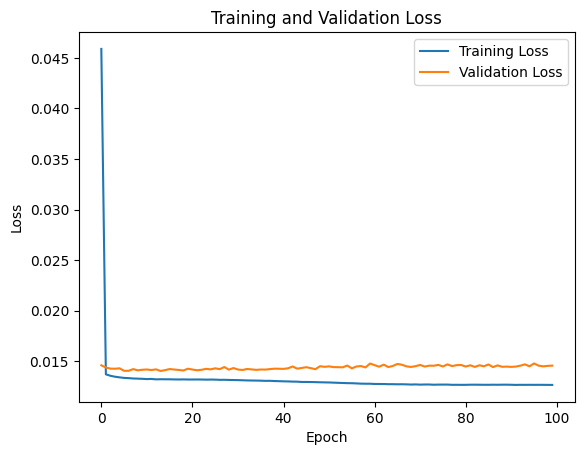

In [26]:
# Plot losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test

Code used to test the obtained models

In [31]:
def test_loop(dataloader, model1, model2, model3):

    model1.eval()
    model2.eval()
    model3.eval()

    model1.to(device)
    model2.to(device)
    model3.to(device)

    errors_model1 = defaultdict(int)
    errors_model2 = defaultdict(int)
    errors_model3 = defaultdict(int)
    label_counts = defaultdict(int)

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs_model1 = model1(inputs)
            outputs_model2 = model2(inputs)
            outputs_model3 = model3(inputs)

            preds_model1 = torch.argmax(outputs_model1, dim=1)
            preds_model2 = torch.argmax(outputs_model2, dim=1)
            preds_model3 = torch.argmax(outputs_model3, dim=1)

            for label, pred1, pred2, pred3 in zip(labels, preds_model1, preds_model2, preds_model3):
                label_counts[label.item()] += 1
                if pred1 != label:
                    errors_model1[label.item()] += 1
                if pred2 != label:
                    errors_model2[label.item()] += 1
                if pred3 != label:
                    errors_model3[label.item()] += 1

    error_rates_model1 = {label: errors_model1[label] / count
                          for label, count in label_counts.items()}
    error_rates_model2 = {label: errors_model2[label] / count
                          for label, count in label_counts.items()}
    error_rates_model3 = {label: errors_model3[label] / count
                          for label, count in label_counts.items()}

    labels = sorted(label_counts.keys())
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x , [error_rates_model1[label] for label in labels], width=0.2, label='All Labels Model')
    ax.bar(x + 0.2, [error_rates_model2[label] for label in labels], width=0.2, label='Reconstructed Model')
    ax.bar(x + 0.4, [error_rates_model3[label] for label in labels], width=0.2, label='Original Model')

    ax.set_xlabel('Labels')
    ax.set_ylabel('Error Rate')
    ax.set_title('Error Rates per Label')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

def test(model, test_dataset, idx):
    base_model_weights, weights, g_cnn, arch, excluded_labels, used_labels = test_dataset[idx]

    base_model = TinyCNN()
    base_model.load_state_dict(base_model_weights)

    batch = Batch.from_data_list([g_cnn]).to(device)

    model.eval()
    reconstructed = model(batch, excluded_labels.to(device).unsqueeze(0)).squeeze()

    new_arch = graph_to_arch(arch, reconstructed)
    reconstructed_model = TinyCNN()
    reconstructed_model.model = arch_to_sequential(new_arch, reconstructed_model.model)

    original_model = TinyCNN()
    new_arch = graph_to_arch(arch, weights)
    original_model.model = arch_to_sequential(new_arch, original_model.model)

    print(f"Loss: {nn.MSELoss()(reconstructed, weights)}")

    subset_mnsit100_mean, subset_mnsit100_std = compute_mean_std(MNIST100Subset(data_mnist['train_images'], data_mnist['train_labels'], used_labels, transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((28, 28)),
                                        ])))

    subset_mnsit100 = MNIST100Subset(data_mnist['train_images'], data_mnist['train_labels'], used_labels, transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Resize((28, 28)),
                                                transforms.Normalize(subset_mnsit100_mean, subset_mnsit100_std)
                                            ]))


    subset_mnsit100_dataloader = DataLoader(subset_mnsit100, batch_size=64, shuffle=False)

    print(f"Subset of MNIST100 on which we are testing: {used_labels}")
    print(f"Lables excluded: {excluded_labels} [1 is retained, 0 is excluded]")
    test_loop(subset_mnsit100_dataloader, base_model, reconstructed_model, original_model)

Excluded labels: 0, 4
Dataset on which weights were trained: 10-0-87-7-2
Loss: 0.015249541960656643


<ipython-input-28-2238dae1cf12>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_indices = torch.tensor(node_indices, dtype=torch.long, device=edge_index.device)


Subset of MNIST100 on which we are testing: [10, 0, 87, 7, 2]
Lables excluded: tensor([0, 1, 1, 1, 0], dtype=torch.int32) [1 is retained, 0 is excluded]


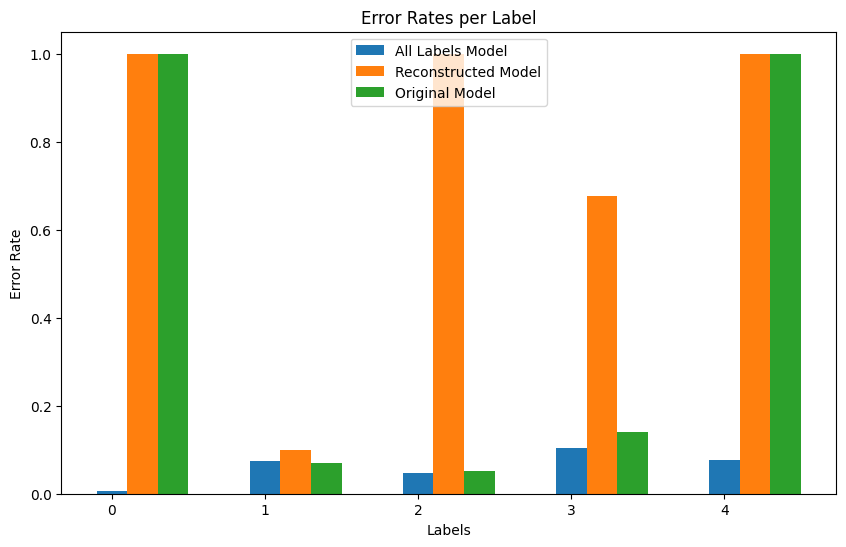

In [32]:
test(model, test_dataset, 40)

### Mia Attack

In [33]:
# Load MNIST Dataset
data = load('mnist_compressed.npz')

In [34]:
def compute_losses_recon_model(model, inputs, labels):

    model.eval()
    model.to(device)

    all_losses = []

    with torch.no_grad():
            output = model(inputs)
            losses = F.nll_loss(output, labels, reduction="none").detach().cpu().numpy()

            for l in losses:
                all_losses.append(l)

    return np.array(all_losses)

In [35]:
idx = 44
base_model_weights, weights, g_cnn, arch, excluded_labels, used_labels = test_dataset[idx]

retain_labels = set([i for i, e in enumerate(excluded_labels) if e == 1])
forget_labels = set([i for i, e in enumerate(excluded_labels) if e == 0])


data_mean, data_std = compute_mean_std(MNIST100Subset(data['train_images'], data['train_labels'], used_labels, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((28, 28)),
                            ])))

dataset = MNIST100Subset(data['train_images'], data['train_labels'], used_labels, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((28, 28)),
                            transforms.Normalize(data_mean, data_std)
                            ]))

train_data = torch.stack(dataset.filtered_data).float()
train_labels = torch.tensor(dataset.filtered_labels)

retain_mask = ~torch.tensor([label.item() in retain_labels for label in train_labels])
forget_mask = ~torch.tensor([label.item() in forget_labels for label in train_labels])

retain_subset_data = train_data[forget_mask].to(device)
retain_subset_labels = train_labels[forget_mask].to(device)
forget_subset_data = train_data[retain_mask].to(device)
forget_subset_labels = train_labels[retain_mask].to(device)

print(f"Subset of MNIST100 on which we are testing: {used_labels}")
print(f"Lables excluded: {excluded_labels} [1 is retained, 0 is excluded]")


Excluded labels: 2, 3
Dataset on which weights were trained: 10-0-87-7-2
Subset of MNIST100 on which we are testing: [10, 0, 87, 7, 2]
Lables excluded: tensor([1, 1, 0, 0, 1], dtype=torch.int32) [1 is retained, 0 is excluded]


In [36]:
# Base model (Knows every class)
base_model = TinyCNN()
base_model.load_state_dict(base_model_weights)

# Compute losses on retain and forget set
retain_losses = compute_losses_recon_model(base_model, retain_subset_data, retain_subset_labels)
forget_losses = compute_losses_recon_model(base_model, forget_subset_data, forget_subset_labels)


batch = Batch.from_data_list([g_cnn]).to(device)

# Reconstructed model
model.eval()
reconstructed = model(batch, excluded_labels.to(device).unsqueeze(0)).squeeze()
new_arch = graph_to_arch(arch, reconstructed)
reconstructed_model = TinyCNN()
reconstructed_model.model = arch_to_sequential(new_arch, reconstructed_model.model)

# Compute losses on retain and forget set
retain_losses_reconstructed = compute_losses_recon_model(reconstructed_model, retain_subset_data, retain_subset_labels)
forget_losses_reconstructed = compute_losses_recon_model(reconstructed_model, forget_subset_data, forget_subset_labels)

# Original model (Label)
original_model = TinyCNN()
new_arch = graph_to_arch(arch, weights)
original_model.model = arch_to_sequential(new_arch, original_model.model)

# Compute losses on retain and forget set
retain_losses_original = compute_losses_recon_model(original_model, retain_subset_data, retain_subset_labels)
forget_losses_original = compute_losses_recon_model(original_model, forget_subset_data, forget_subset_labels)

<ipython-input-28-2238dae1cf12>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_indices = torch.tensor(node_indices, dtype=torch.long, device=edge_index.device)


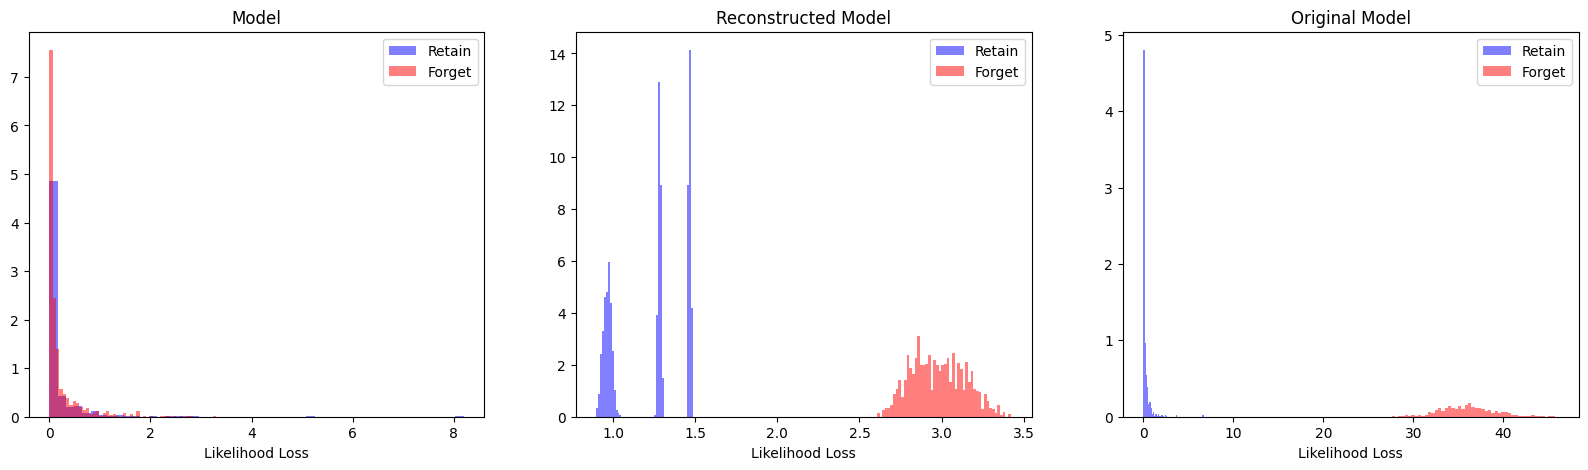

In [ ]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

m = min(len(retain_losses), len(forget_losses))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(m), m, replace=True)

axs[0].hist(retain_losses[random_idx], density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses[random_idx], density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Likelihood Loss')
axs[0].legend()

axs[1].hist(retain_losses_reconstructed[random_idx], density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_reconstructed[random_idx], density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Reconstructed Model')
axs[1].set_xlabel('Likelihood Loss')
axs[1].legend()

axs[2].hist(retain_losses_original[random_idx], density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_original[random_idx], density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Original Model')
axs[2].set_xlabel('Likelihood Loss')
axs[2].legend()

plt.show()

In [41]:
from sklearn import linear_model, model_selection
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    torch.manual_seed(torch.initial_seed())

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy",
    )

In [42]:
# mia on base model
retain_losses_model_subsample = np.random.choice(retain_losses, m, replace=False)
forget_losses_model_subsample = np.random.choice(forget_losses, m, replace=False)
samples_mia = np.concatenate([retain_losses_model_subsample, forget_losses_model_subsample]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_model_subsample)), np.ones(len(forget_losses_model_subsample))])

scores = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores.mean():.4f}")

Model MIA score: 0.5506


In [43]:
# mia on reconstructed model
retain_losses_recon_subsample = np.random.choice(retain_losses_reconstructed, m, replace=False)
forget_losses_recon_subsample = np.random.choice(forget_losses_reconstructed, m, replace=False)
samples_mia = np.concatenate([retain_losses_recon_subsample, forget_losses_recon_subsample]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_recon_subsample)), np.ones(len(forget_losses_recon_subsample))])

scores_recon = simple_mia(samples_mia, members_mia)
print(f"Reconstructed Model MIA score: {scores_recon.mean():.4f}")

Reconstructed Model MIA score: 1.0000


In [44]:
# mia on original model
retain_losses_original_subsample = np.random.choice(retain_losses_original, m, replace=False)
forget_losses_original_subsample = np.random.choice(forget_losses_original, m, replace=False)
samples_mia = np.concatenate([retain_losses_original_subsample, forget_losses_original_subsample]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_original_subsample)), np.ones(len(forget_losses_original_subsample))])

scores_original = simple_mia(samples_mia, members_mia)
print(f"Original Model MIA score: {scores_original.mean():.4f}")

Original Model MIA score: 1.0000



# Report
For the unlearning task we choose to train a model (with the help of the GMN model) to get in input the weights of a model $M$ and a binary encoding $O$ representing the labels to forget (where 1 means retained and 0 is excluded) and gives in output the weights of a model $M'$ such that $M$ classify 5 classes (it has a good accuracy on all the 5 classes) and $M'$ forgets 1 to 4 of those classes (it has a bad accuracy on the classes to be forgotten and still a good accuracy on the remaning classes) based on the binary representation $O$ that specifies what classes it has to forget.

A general pipeline can be sketched as follows:
- First of all, we generate a dataset of CNN weights trained on different subsets of MNIST100 (we are going to justify this choice later in the report)
- Second, we take the dataset of weights and train a model that takes in input the CNN trained on all the labels of that particular dataset, plus the labels we would like to forget.
- In this way the gmn extract the encodings of the model edges and nodes, that are then passed through convolutional layers to reduce their dimensionality and extract features.
- The tensors extracted with convolutions are then stacked together with the excluded labels and passed through some transposed convolutions to obtain the final tensor of reconstructed weights

Given the explanation, we can think about the Weights Reconstructor Model as a sort of AutoEncoder, where the encoder $E$ is composed of the GMN and the convolution operations, and the decoder $D$ are the transposed convolutions.

So, given the weights $w$ of the model we would like to reconstruct, that is the one with unlearned classes, the loss is going to be:

$$ l = MSE(w, D(E(w))) $$

The final idea is that, by just passing the label to exclude and a general CNN trained on a different subset of MNIST with respect the model training weights, the  Weights Reconstructor Model will be able to reconstruct the weights of such unlearned model.

Our idea is vaguely inspired from this [paper](https://arxiv.org/abs/2212.04089), in which the authors makes models unlearn with simple arithmetic operations on weights. Even if our approach is very much different, we wanted to leverage the concept of vectors encoding informations about the weights by training the Weights Reconstructor in regenerating model weights.

## Dataset
We created a dataset of CNN weights. We trained a single tiny network, **TinyCNN**, on a MNIST-100 dataset that has 100 classes, splitting it in $\frac{100}{5} = 20\ $  subsets (each one contaning 5 classes). Formally, calling $D$ the whole MNIST-100 dataset and $D_{i, i+5}$ a subset of said MNIST-100, we have:
$$ \bigcup\limits_{k=0}^{19} D_{5k, 5k+5} = D$$
$$ \bigcap\limits_{k=0}^{19} D_{5k, 5k+5} = \emptyset$$

**NOTE** Even if the notation here used suggest that the subsets of MNIST-100 are created taking contigous labels (e.g $D_{5,10}$ contains the labels from 5 to 10, $D_{10,15}$ contains the labels from 10 to 15, etc...), the actual subset have different shuffled labels (e.g We have a subset with labels $10, 0, 87, 7, 2$). This is done to avoid introducing a bias over the weights. For simplicity, we leave the notation as it is, meaning that when we write $D_{i,i+5}$ we want to say that we a subset of MNIST-100 with 5 labels.

Then for each subset $D_{i, i+5}$ we trained one model excluding 1 to 4 classes for every different combination of those classes. If we represent the labels as binary encodings, where 1 is retained and 0 is forget, we have, for each subset, the following:
\begin{equation} [0,0,0,0,0],[1,0,0,0,0],\dots,[1,1,0,0,0],[1,0,1,0,0],\dots,[1,1,1,1,0],[0,1,1,1,1] \end{equation}
So we have $\binom{5}{0} + \binom{5}{1} + \binom{5}{2} + \binom{5}{3} + \binom{5}{4} = 31 $ possible combination of removed classes and for each of the 20 subset of MNIST-100 we have a total of $31×20 = 620$ models in our dataset.

We choose to train a model with just 5 labels to predict because in this way we had a faster dataset generation $ \bigl( \sum_{k=0}^{4} \binom{5}{k}  << \sum_{k=0}^{9} \binom{10}{k} \bigl) $ and a greater accuracy for each of the subset of MNIST-100

***

*Why training a single CNN on MNIST-100?*

First of all, MNIST images are gray scale, meaning that we require less parameters in the convolutional layers. Second, we had three very hard constrains:

- **TIME**
    Creating a dataset full of CNN weights means to train said network on tens of differents datasets, so we need a lot of time. We tried squeezing every second out of this process, with different optimizations, and we managed to create a small dataset in few minutes, but the time requirement is still very important. With a larger network or larger datasets, few minutes could translate to days

- **SPACE**
    Having a bigger network would be very useful in order to test this on CIFAR10 or other type of RGB images, but, assuming to have the datasets on which to train the network, saving the weights for each of those datasets would mean to have a very large dataset.

- **RECONSTRUCTION SIZE**
    For simplicity, our architecture used to reconstruct model weights outputs always a constant number of values. We speculated that for different models with different sizes a _sequence model_ could have been used, but this would introduce problems on its own, and we decided to further trivialize the problem to show our approach in a simpler way.

Also, we thought that having different weights all trained on a very simple and similar domain for each of them would have helped a lot in creating a toy problem on which to train the Weights Reconstructor.

***

The various optimizations used to train the network are partially taken from this [repo](https://github.com/tuomaso/train_mnist_fast), in which the author trains a CNN on MNIST in 700ms.
In a nutshell, the biggest time consuming operation is the Dataloader, so just a simple manual slicing helps a lot with the time performances.

#### TinyCNNs performance
The dataset's models have to be big enough to reach a good accuracy but small enough to be trained fast and effectively on the GMN.
We trained the TinyCNN on the training set of the subsets of MNIST-100 and computed also the accuracy on test set to check eventual overfittings. In particular, for each subset we print the accuracy on the retain test set (test set with retained labels) and the accuracy over the whole test set (test set with all labels).

## Model

As explained above, the idea is to have an architecture that can take a CNN model $M$ trained on all the labels of a subset $D_{i, i+5}$, along with the labels we would like to forget, represented as a binary encoding (e.g. $[1,1,0,0,0]$ means retain the first and second label and forget the others), to obtain in output the weights of a model $M'$ that has forgot the indicated labels.

The pipeline of the model is as follows:

1. Take a batch of graphs in inputs (e.g $B$ is the number of graphs in the batch)
2. Return nodes encodings, edges encodings and global encodings (we do not use the latters) (e.g. We obtain tensors of shape $(B \times N, F_x)$ for the nodes and $(B \times E, F_e)$ for the edges)
3. Debatchify the batched graph to obtain the single graphs
4. Extract nodes and edges for each graph (e.g. We obtain $B$ tensors of shape $(N, F_x)$ for the nodes and $(E, F_e)$ for the edges)
5. Rebatchify the nodes and edges (e.g. We obtain tensors of shape $(B, N, F_x)$ for the nodes and $(B, E, F_e)$ for the edges)
6. Pass those tensors into 1D convolutions (with a final flatten and linear layer) to extract features and reduce dimensionality (e.g We obtain tensors of shape $(B, D_x)$ for the nodes and $(B, D_e)$ for the edges)
7. Concatenate all along with binary labels representation (e.g We obtain a tensor of shape $(B, D_x + D_e + 5)$)
8. Pass this tensor into a linear layer to encode informations into a tensor of fixed size (e.g The tensor obtained has shape $(B, L)$)
9. Reshape the tensor to match a 2D representation to better reconstruct using transposed convolutions (e.g We reshape it to be $(B, 3, L/3)$)
10. Pass it through transposed convolutions and flatten+linear layer to obtain final reconstructed weights

Our idea was that the Weight Reconstructor could have learned how to reconstruct weights from the tensor obtained at step 8 that was encoding all the informations needed for this task. Like latent codes in actual AEs, we were hoping to obtain something similar with a vector carrying encoded informations about the network, the weights and the labels to forget.

#### Training

We splitted the weights dataset into training, validation and test set. Note that this splitting is not performed on all the weights shuffled, but we take the weights trained on specific subset of MNIST-100, so it would be more correct to think about this splitting as taking percentages of subsets weights of MNIST-100. To be more specific, let's imagine to have a train percentage of 80%, validation of 10% and testing 10%. We know that there are 20 subset $D_{i, i+5}$ of the original $D$, the MNIST-100 dataset. Thus, we have:

- **Train** $\rightarrow \{D_{5k, 5k+5}|k \in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]\} $
- **Val**   $\rightarrow \{D_{5k, 5k+5}|k \in [16,17]\} $
- **Test**  $\rightarrow \{D_{5k, 5k+5}|k \in [18,19]\} $

***

*Why this splitting?*

Taken a fixed CNN, the idea is to train the Weights Reconstructor on weights coming from the training on a particular subset. If the Weights Reconstructor has to be tested on never seen before data, it is pretty clear that we need to pass weights that comes from a training on different subsets, otherwise those weights would not be never seen before.

***

During training, the model trained on all the labels of a particular subset $D_{i, i+5}$ is passed to the architecture along with the labels we would like to forget. The reconstructed weights are then used to compute the loss with the weights of the model that was trained on the subset $D_{i, i+5}$ but just with the retained labels. We used the MSE loss because we are doing regression on models weights values.

## Performance
This approach, unfortunately, did not work very well. We couldn't make the model converge: it only learned to predict a few TinyCNN (that were all ground-truths in the training set) indipendently of the input and couldn't generalize. In order to help the model not overfit and make it better in generalization we tried to change the model size, both increasing it and decreasing it. We also tried some other techniques including Dropout and Weight Decay (L2 regularization), with no effect. Finally, we also tried to encode the binary representations with linear layers before stacking them along with the features, but that did not help at all. We believe those probleme were caused by two main facts:
- The dataset is not very diverse and has a small size
- The approach we used, that is "learning to predict weights as similar as possible to the ground truth", is too simplistic (more on this in the section *Future developments*).


### A closer look to Performance
Given the information we had, we tried to dive deeper into the analysis, trying to understand why the model was not working. We started by printing the encodings from the GMN for some inputs and we noticed they were, for the most part, equal. In other words the model was probably oversmoothing, in the sense that the GNN layers were making the encodings converge to the same value, hence the model was not working properly. Probably the nodes of the CNN are too few, and just two layers in the GMN are enough to lead to this phenomenon. This could be a good explanation to why the model is so poor: each input leads to the same (or almost the same) encoding, so the output of the model is always the same.

### Mia Attack
We performed the Mia Attack on the Test set of our weights dataset. We expect the Attack to work very well, since the model is not working and it always predicts a Model that does not recognize the Forget set.

In the image below we used the following notation: *Model* is the model that can recognize every class, *Reconstructed Model* is *Model* that has unlearned the Forget set and *Original Model* is the ground truth model that was trained to recognize only the Retain set. As we can see in the image below the attack works very well: there is a very distinct division between the losses calculated on the Retain and Forget set for both *Reconstructed Model* and *Original Model*. This was completely expected, for the motivations exaplained earlier. We can also notice that the *Reconstructed Model* losses were a bit higher than the ones of *Original Model* for the Retain set. This is because the *Reconstructed Model* only knows how to classify a single class (this behaviour was described earlier).
<div style="text-align: center;">
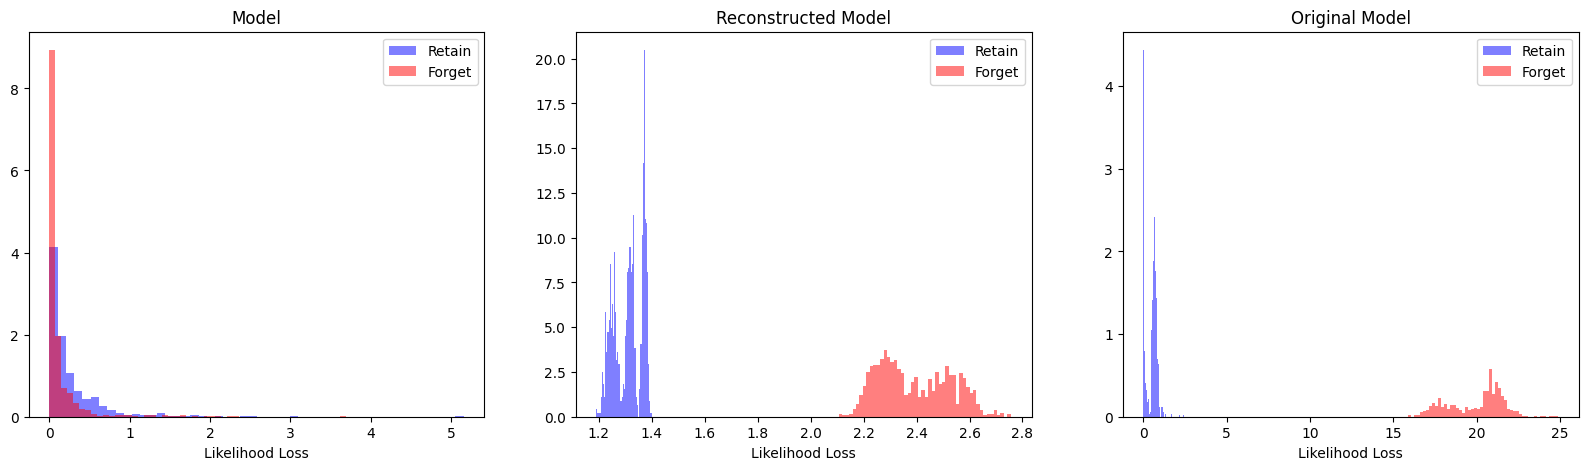
</div>

Finally we had Mia Scores of $≈0.55$ for *Model* and $1$ for *Reconstructed Model* and *Original Model*. These scores seem very good: we know precisely which model used the Forget set in the training set (only the first), but the *Reconstructed Model* yields this value just because the model is not working properly. Of course, by just having as output a TinyCNN that was part of the training set and was only trained on the Retain set, it's trivial that the Mia Attack works.
## Future developments

Our approach did not work at all, so we tried to research some methods to prevent the oversmoothing we observed. Unfortunately we did not have enough time to try them, but the idea for a possible future development is to:
- Make the TinyCNN a NotSoTinyCNN larger than the former in order to have bigger graph
- Use Skip Connections.

Even tho these solutions could help, we would also probably try a different approach. We thought that just using the MSE between reconstructed weights and original weights is not enough to learn something meaningful in order to have a functioning model. We tried this approach just to have a solid ground base to start, but it took more time than expected. We speculate that an hybrid approach involving also the calculation of actual performances of reconstructed models inside the loss could indeed help the Weights Reconstructor. In other words a good approach might be to predict a model and test it for the actual task (predicting one or more less classes). In other words the loss would be the measure of "how good the predicted model performs on the Retain set". We believe this approach could work very well and would be interesting to explore in the future.

Finally a bigger dataset, both in size and variety, could be created. This, combined with the other approaches described, would indeed help to create a possible good model. 

## Participants and data

Paolo Cursi 2155622 - cursi.2155622@studenti.uniroma1.it

Pietro Signorino 2149741 - signorino.2149741@studenti.uniroma1.it

Stefano Saravalle 1948684 - saravalle.1948684@studenti.uniroma1.it

Michele Palma 1849661 - palma.1849661@studenti.uniroma1.it

The MNIST-100 dataset and the weights dataset can be found at the following link: [Drive](https://drive.google.com/drive/folders/1_aE2UYEJxEsHUDIWOKL01BVPcrWZrHr4?usp=sharing)